In [88]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from scipy.signal import convolve2d
from sklearn.decomposition import PCA
from scipy.stats import sem, pearsonr
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Changes from previous versions:
- Constrain spacing by photoreceptor spacing
- Constrain width by visual field of salamander retina  
- Constrain output power instead of output variance

In [2]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = retina_width//photoreceptor_width
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

### Load receptive fields

In [3]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells(space_mode='peak')
cells['bipolar'] = load_bipolar_cells(space_mode='peak')
cells['amacrine'] = load_amacrine_cells(space_mode='peak')
cells['horizontal'] = load_horizontal_cells(space_mode='peak')

In [4]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))
        
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)

In [5]:
# David's 1721 receptive field dataset
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        this_space = get_space(g_pca, spatialDelta, micronsPerDeg, kind='peak')
        
        rf_interp = interp1d(this_space, sign_of_pc*g_pca, kind='slinear', bounds_error=False, fill_value=[0])

        receptive_fields[celltype].append(rf_interp(space))

#### Remove duplicates

In [6]:
corr_map = {}
for celltype in receptive_fields.keys():
    corr_map[celltype] = np.zeros((len(receptive_fields[celltype]), len(receptive_fields[celltype])))
    for idr1, rf1 in tqdm(enumerate(receptive_fields[celltype])):
        for idr2 in range(idr1+1, len(receptive_fields[celltype])):
            rf2 = receptive_fields[celltype][idr2]
            corr_map[celltype][idr1, idr2] = pearsonr(rf1, rf2)[0]

unduplicated_receptive_fields = collections.defaultdict(list)
duplicates = collections.defaultdict(list)

for celltype in corr_map.keys():
    these_dups = []
    for row in corr_map[celltype]:
        these_dups.append([i for i in range(len(row)) if row[i] == 1.0])
    duplicates[celltype] = np.unique(np.hstack(these_dups))
    
unduplicated_receptive_fields = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    for idr, rf in enumerate(receptive_fields[celltype]):
        if idr not in duplicates[celltype]:
            unduplicated_receptive_fields[celltype].append(rf)
            
receptive_fields = unduplicated_receptive_fields.copy()
del unduplicated_receptive_fields

sum([len(receptive_fields[k]) for k in receptive_fields.keys()]) - sum([len(receptive_fields[k]) for k in ['horizontal',
                                                                                                           'amacrine',
                                                                                                          'bipolar']])

1382

### Compute projective fields

In [7]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

### Signal

In [8]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing = 1./pixelsToDeg # number of degree spacing between pixels
normalize = 'divisive'
contrast = 0.35
signal = np.array(np.load('signal_3_23.npy'))

### Noise  
Note that the amplitude of the average_ganglion_fft will change the SNR. As the amplitude $\rightarrow \infty$, we get $$\rm{SNR} \rightarrow \frac{\sum (\rm{filter}_{1:f} \times \rm{signal}_{1:f})^2}{\sum (\rm{filter}_{1:f} \times N_{\rm{in}})^2}$$.  

Since the scale of the ganglion fft is arbitrary, we can look at the SNR in this limit.

In [9]:
input_noise = 0.098762200628786892
output_noise = 0.35
target_power = 54.131410989171826

In [10]:
# SNR = 0.269 is total SNR from ganglion recordings of 112 repeats to 30 seconds natural scenes
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
def find_filt_const(filt_const):
    this_snr = get_snr(input_noise, output_noise, signal, filt_const*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

filt_const_opt = scipy.optimize.minimize_scalar(find_filt_const)

print(get_snr(input_noise, output_noise, signal, filt_const_opt.x*average_ganglion_fft, mode='variance'))

0.269124689452


### Ideal filter

In [11]:
ideal_filter = unique_soln(signal**2, input_noise, output_noise)

The relative error from this choice of Lagrangian multiplier is 4.1546047327e-07.


### Model of Horizontal Projective Field + Amacrine Projective Field + Center

In [12]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

Get center widths for each celltype

In [13]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0)

In [14]:
def center_and_surround(space, center_width, surround_width, center_strength, surround_strength):
    return diff_of_gauss_mu0(space, abs(center_width), abs(surround_width),
                            -abs(center_strength), abs(surround_strength))

In [15]:
center_widths = np.load('center_widths_3_29.npy').item()
surround_widths = np.load('surround_widths_3_29.npy').item()
center_strengths = np.load('center_strengths_3_29.npy').item()
surround_strengths = np.load('surround_strengths_3_29.npy').item()
fit_failures = np.load('fit_failures_3_29.npy').item()

In [16]:
for f in fit_failures.keys():
    print("couldn't fit %d in %s" %(len(fit_failures[f]), f))

couldn't fit 4 in fast_off_adapting
couldn't fit 3 in fast_off_sensitizing
couldn't fit 13 in slow_off
couldn't fit 4 in medium_off_adapting
couldn't fit 3 in ganglion
couldn't fit 1 in fast_on


In [17]:
median_center_widths = {}
for celltype in center_widths.keys():
    cws = np.array(center_widths[celltype])
    sws = np.array(surround_widths[celltype])
    css = np.array(center_strengths[celltype])
    sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
    median_center_widths[celltype] = np.median(abs(cws))
    median_surround_width = np.median(abs(sws))
    median_center_strength = np.median(-abs(css))
    median_surround_strength = np.median(abs(sss))
#     plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
#                                      median_center_strength, median_surround_strength), label=celltype)
# plt.legend(frameon=False, fontsize=9, loc='lower left')
# adjust_spines(plt.gca())

median_center_widths

{'fast_off_adapting': 1.6921005209471627,
 'fast_off_sensitizing': 2.0456543257003039,
 'fast_on': 2.1703662900605498,
 'ganglion': 1.3731413963691115,
 'medium_off_adapting': 1.555772399380934,
 'slow_off': 1.5248731503974167}

# Compute information while varying surround widths

In [18]:
widths = np.linspace(0.01, 17, 100)
init_filt_const = 10.9
resolution = 100
horz_weights = np.linspace(0,1,resolution)
center_weights = np.linspace(0,1,resolution)

In [19]:
infos_varying_width = collections.defaultdict(list)
celltype = 'fast_off_adapting'
with h5py.File('infos_varying_width.h5', 'r') as f:
    tmp = dict(f)
    width_tuples = list(tmp.keys())
    for k in width_tuples:
        lhs, rhs = k.split(',')
        w1 = float(lhs.split('(')[1])
        w2 = float(rhs.split(')')[0])
        infos_varying_width[(w1, w2)] = np.array(f[k])

In [20]:
colorscheme = {
    'ganglion': 'k',
    'fast_off_sensitizing': 'r',
    'fast_off_adapting': 'g',
    'slow_off': 'y',
    'fast_on': 'b',
    'medium_off_adapting': 'c'
}

For each cell type, there is a map of information as a function of the two surround sizes. For each of these maps is another map of how information varies with weighting, conditioned on the two surround sizes.

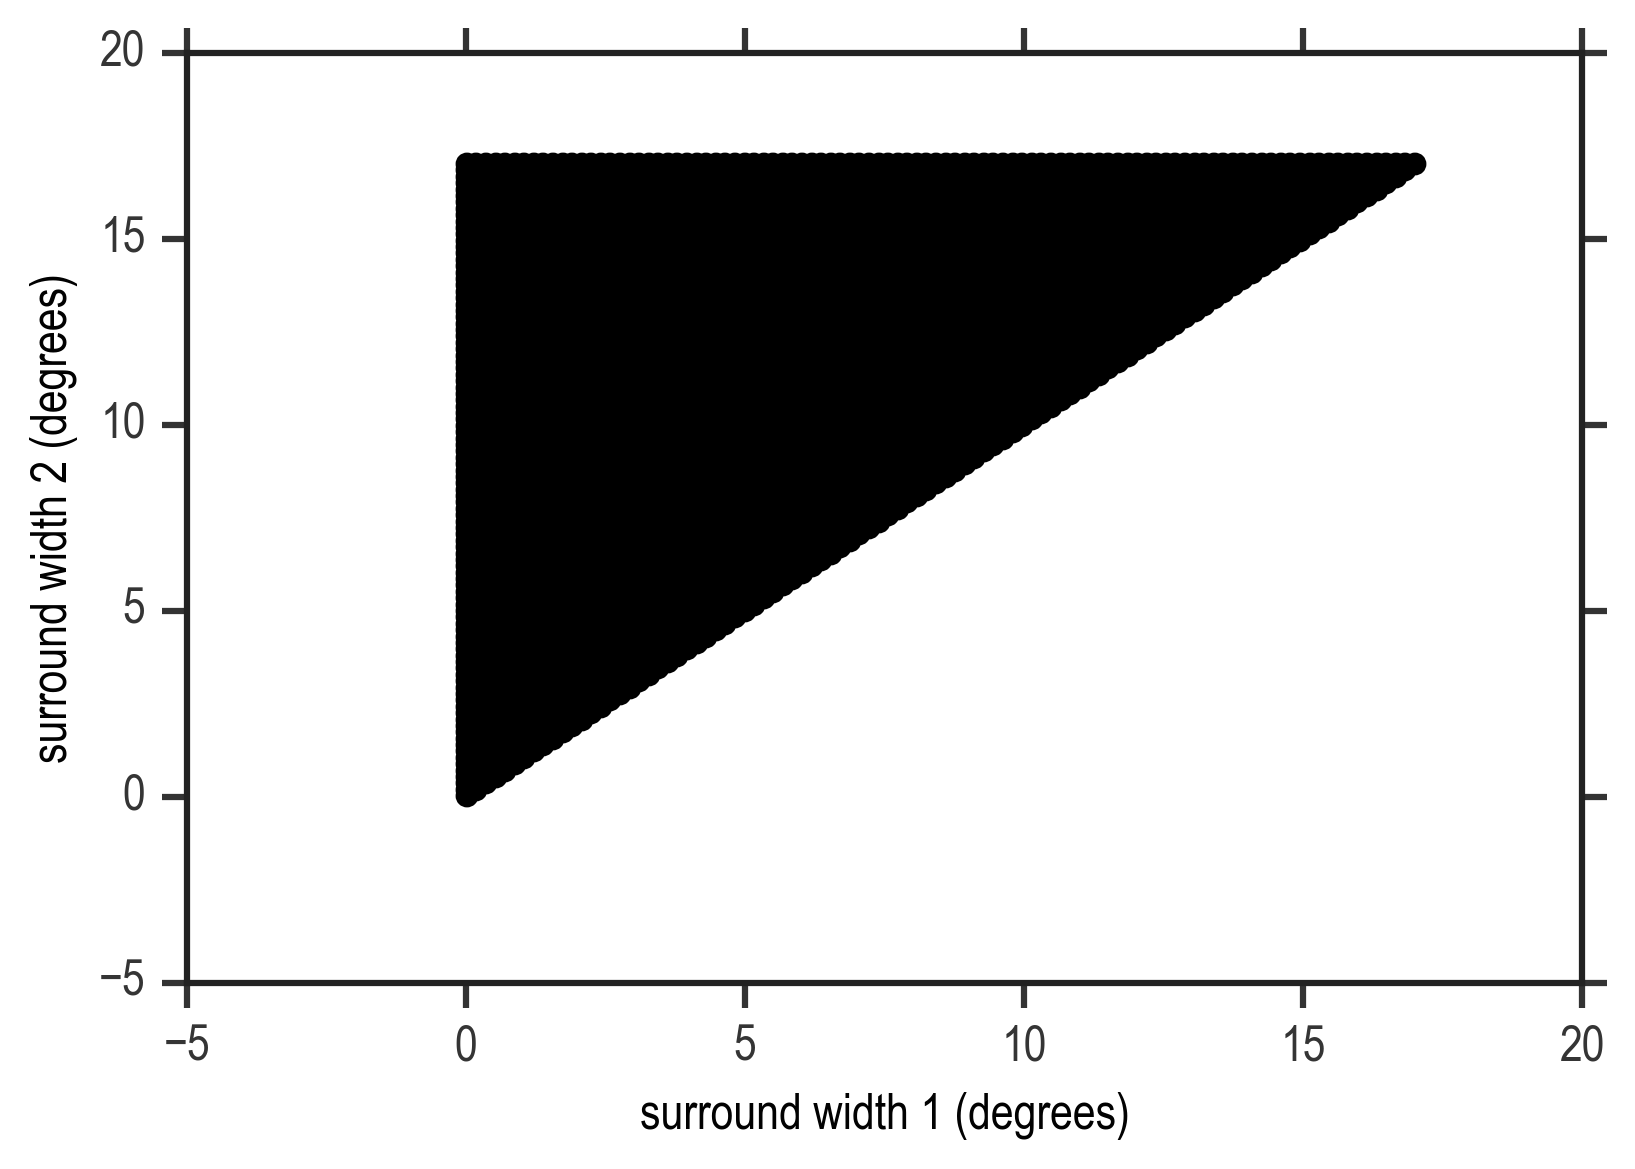

In [21]:
celltype = 'fast_off_adapting'
for idw,w1 in enumerate(widths):
    for w2 in widths[idw:]:
        plt.scatter(w1, w2, color='k')
plt.xlabel('surround width 1 (degrees)')
plt.ylabel('surround width 2 (degrees)')

In [22]:
max_info_vs_width = np.zeros((len(widths), len(widths)))
for idw1,w1 in enumerate(widths):
    for idw2,w2 in enumerate(widths[idw1:]):
        max_info_vs_width[idw1, idw2+idw1] = np.max(infos_varying_width[(w1,w2)])
        max_info_vs_width[idw2+idw1, idw1] = np.max(infos_varying_width[(w1,w2)])

In [23]:
popt_horz, pcov = curve_fit(gaussian, space, horz_pf, p0=[2.5, 0.0, 2.1])
popt_ama, pcov = curve_fit(gaussian, space, ama_pf, p0=[2.5, 0.0, 2.1])

In [24]:
min_info = None
max_info = None
for idw1,w1 in enumerate(widths):
    for idw2,w2 in enumerate(widths[idw1:]):
        new_min = np.min(infos_varying_width[(w1,w2)])
        new_max = np.max(infos_varying_width[(w1,w2)])
        if (not min_info) or (min_info > new_min):
            min_info = new_min
        if (not max_info) or (max_info < new_max):
            max_info = new_max

In [25]:
max_info

9.4720612730635256

# Plot all horizontal, amacrine cell data on the info maps

In [26]:
data_dir = os.path.expanduser('~/data/kastner/')
h_file = 'horizontals.h5'
a_file = 'amacrines.h5'

In [27]:
interneuron_rfs = collections.defaultdict(list)
with h5py.File(data_dir + h_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        rf = np.array(f['lines/rfs/%s' %expt])
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        interneuron_rfs['horizontal'].append(sign_of_pc * g_pca)

with h5py.File(data_dir + a_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        rf = np.array(f['lines/rfs/%s' %expt])
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        interneuron_rfs['amacrine'].append(sign_of_pc * g_pca)

In [28]:
space_constant = {
    'horizontal': 118./microns_per_degree,
    'amacrine': 78./microns_per_degree
    }
conv_mode = 'full'
# spatial delta in mm * 1000) / microns_per_degree # microns * degrees/microns = degrees
interneuron_spacing = (2.2/100.) # in mm

interneuron_rfs_1d = collections.defaultdict(list)
for interneuron_type in interneuron_rfs.keys():
    for rf in interneuron_rfs[interneuron_type]:
        this_space = get_space(rf, interneuron_spacing, microns_per_degree, in_degrees=True, kind='peak')
        proj_range = [np.exp(-abs(t)/space_constant[interneuron_type]) for t in np.linspace(np.min(this_space),
                                                                                    np.max(this_space),len(this_space))]
        proj_field = np.convolve(proj_range, rf, mode=conv_mode)
        proj_field *= np.mean(rf) / np.mean(proj_field)
        
        proj_space = get_space(proj_field, np.diff(this_space[:2]), microns_per_degree, in_degrees=False)
        component_interp = interp1d(proj_space, proj_field, kind='slinear', bounds_error=False, fill_value=[0])
        interneuron_rfs_1d[interneuron_type].append(component_interp(space))

In [29]:
colorscheme = {
    'horizontal': 'g',
    'amacrine': 'b'
}

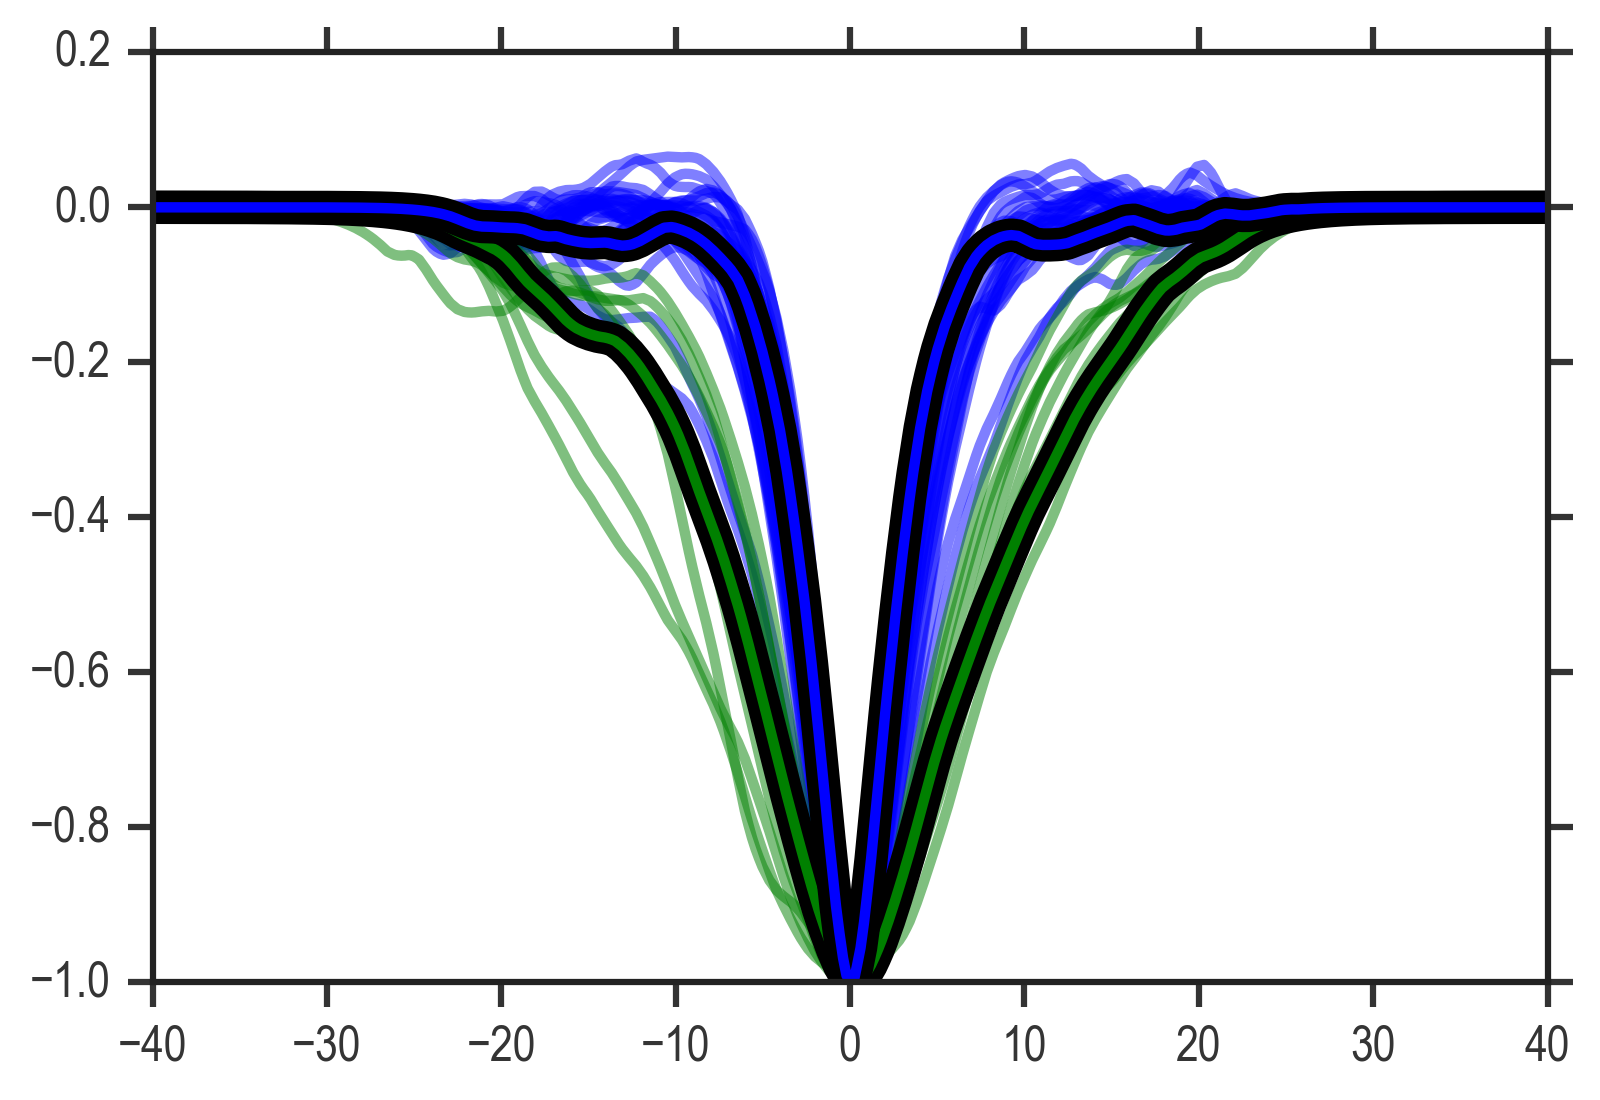

In [30]:
interneuron_fits = collections.defaultdict(list)
for interneuron_type in interneuron_rfs_1d.keys():
    for component in interneuron_rfs_1d[interneuron_type]:
        plt.plot(space, component/np.max(abs(component)), color=colorscheme[interneuron_type], alpha=0.5)

plt.plot(space, -horz_pf/np.max(abs(horz_pf)), 'k', linewidth=8)
plt.plot(space, -horz_pf/np.max(abs(horz_pf)), 'g')
plt.plot(space, -ama_pf/np.max(abs(ama_pf)), 'k', linewidth=8)
plt.plot(space, -ama_pf/np.max(abs(ama_pf)), 'b')

In [31]:
interneuron_fits = collections.defaultdict(list)
for interneuron_type in interneuron_rfs_1d.keys():
    for component in interneuron_rfs_1d[interneuron_type]:
        popt, pcov = curve_fit(gaussian, space, -component, p0=[2.5, 0.0, 2.1])
        interneuron_fits[interneuron_type].append(abs(popt[0]))

### Try contour plot

In [32]:
count_horz, horz_edges = np.histogram(interneuron_fits['horizontal'], bins=widths)
count_ama, ama_edges = np.histogram(interneuron_fits['amacrine'], bins=widths)

# widths_high_res = np.linspace(widths[0], widths[-1], 50)
# count_horz, horz_edges = np.histogram(interneuron_fits['horizontal'], bins=widths_high_res)
# count_ama, ama_edges = np.histogram(interneuron_fits['amacrine'], bins=widths_high_res)

In [33]:
interneuron_pairs = np.outer(count_horz, count_ama)

### Define angle between RFs

In [98]:
def angle(rf1, rf2):
    # an arccos(x > 1) returns nan. But we get some values x that are 1.0000000002 due to numerical imprecision
    opp_hyp = np.min([1, np.inner(rf1, rf2)/(np.sqrt(np.sum(rf1**2)) * np.sqrt(np.sum(rf2**2)))])
    a = np.arccos(opp_hyp)
    return np.min([a, abs(a - 2*np.pi)])
#     return np.arccos(np.inner(rf1, rf2)/(np.sqrt(np.sum(rf1**2)) * np.sqrt(np.sum(rf2**2))))

## Get angle difference in RFs as you traverse in vertical direction at peak information  
By vertical direction I mean horizontal (1 - amacrine) difference.  
Note that we can ignore the power constraint, since normalizing by a constant doesn't change the angle.

In [99]:
max_angles_fft = np.zeros((len(widths), len(widths)))
max_angles_rf = np.zeros((len(widths), len(widths)))
info_difference = np.zeros((len(widths), len(widths)))
all_angles = []
all_dots = []
all_arccos = []
all_info_losses = []

center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
center /= -np.sum(center)

for idw1,w1 in enumerate(widths):
    surround1 = gaussian(x=space, sigma=w1, mu=0.)
    surround1 /= np.sum(surround1)
    for idw2,w2 in enumerate(widths[idw1:]):
#         print((w1,w2))
        surround2 = gaussian(x=space, sigma=w2, mu=0.)
        surround2 /= np.sum(surround2)

        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

        this_map = infos_varying_width[(w1,w2)]
        which_fft = np.unravel_index(this_map.argmax(), this_map.shape)
        hw = horz_weights[which_fft[0]]
        cw = center_weights[which_fft[1]]
        
        rf = rf_model(hw, cw)
        rf_filt = abs(np.fft.rfft(rf))
        this_info = infos_varying_width[(w1,w2)][which_fft[0], which_fft[1]]
        max_angle_fft = -1
        max_angle_rf = -1
        for idh,new_hw in enumerate(horz_weights):
#             if w1 != w2:
# #                 if new_hw != hw:
#                 import pdb
#                 pdb.set_trace()
            
            new_rf = rf_model(new_hw, cw)
            new_filt = abs(np.fft.rfft(new_rf))
            new_rf_angle = angle(rf, new_rf)
            new_fft_angle = angle(rf_filt, new_filt)
            
            all_angles.append(new_rf_angle)
            all_dots.append(np.inner(rf, new_rf)/(np.sqrt(np.sum(rf**2)) * np.sqrt(np.sum(new_rf**2))))
            all_arccos.append(np.arccos(np.min([1,all_dots[-1]])))
            all_info_losses.append(infos_varying_width[(w1,w2)][idh, which_fft[1]]/max_info)
            
            if new_rf_angle > max_angle_rf:
                max_angle_rf = new_rf_angle
            if new_fft_angle > max_angle_fft:
                max_angle_fft = new_fft_angle
                new_info = infos_varying_width[(w1,w2)][idh, which_fft[1]]
#                 associated_info_diff = new_info/this_info
                associated_info_diff = new_info/max_info
                
        max_angles_rf[idw1, idw2+idw1] = max_angle_rf
        max_angles_rf[idw2+idw1, idw1] = max_angle_rf
        max_angles_fft[idw1, idw2+idw1] = max_angle_fft
        max_angles_fft[idw2+idw1, idw1] = max_angle_fft
        info_difference[idw1, idw2+idw1] = associated_info_diff
        info_difference[idw2+idw1, idw1] = associated_info_diff

In [100]:
best_indices = []
thresholds = np.linspace(0.01, 0.5, 20)
for thresh in thresholds:
    angles = max_angles_fft.ravel()
    infos = info_difference.ravel()
    local_max_info = 0
    for i,a in enumerate(angles):
        if a > thresh:
            if infos[i] > local_max_info:
                local_max_info = infos[i]
                best_index = np.unravel_index(i, info_difference.shape)
    best_indices.append(best_index)

In [101]:
max_angles_fft_data = []
max_angles_rf_data = []
max_info_difference_data = []

for h_width in interneuron_fits['horizontal']:
    surround2 = gaussian(x=space, sigma=h_width, mu=0.)
    surround2 /= np.sum(surround2)
    
    # choose the closest width in our lookup table
    w2_idx = np.argmin(np.abs(h_width - widths))
    w2 = widths[w2_idx]
    
    for a_width in interneuron_fits['amacrine']:
        surround1 = gaussian(x=space, sigma=a_width, mu=0.)
        surround1 /= np.sum(surround1)
        
        # choose the closest width in our lookup table
        w1_idx = np.argmin(np.abs(a_width - widths))
        w1 = widths[w1_idx]

        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

        if w1 > w2:
            print('Triggered! %f, %f' %(h_width, a_width))
            tmp = w1
            w1 = w2
            w2 = tmp
            
            def rf_model(horz_weight, center_weight):
                return center_weight*center + (1-center_weight)*(horz_weight*surround1 + (1-horz_weight)*surround2)
            
        this_map = infos_varying_width[(w1,w2)]
        which_fft = np.unravel_index(this_map.argmax(), this_map.shape)
        hw = horz_weights[which_fft[0]]
        cw = center_weights[which_fft[1]]
        
        rf = rf_model(hw, cw)
        rf_filt = abs(np.fft.rfft(rf))
        this_info = infos_varying_width[(w1,w2)][which_fft[0], which_fft[1]]
        max_angle_fft = 0
        max_angle_rf = 0
        for idh,hw in enumerate(horz_weights):
            new_rf = rf_model(hw, cw)
            new_filt = abs(np.fft.rfft(new_rf))
            new_rf_angle = angle(rf, new_rf)
            new_fft_angle = angle(rf_filt, new_filt)
            
            if new_rf_angle > max_angle_rf:
                max_angle_rf = new_rf_angle
            if new_fft_angle > max_angle_fft:
                max_angle_fft = new_fft_angle
                new_info = infos_varying_width[(w1,w2)][idh, which_fft[1]]
                associated_info_diff = new_info/this_info
                
        max_angles_rf_data.append(max_angle_rf)
        max_angles_fft_data.append(max_angle_fft)
        max_info_difference_data.append(associated_info_diff)

Triggered! 5.181274, 5.350322
Triggered! 5.181274, 5.670147


In [102]:
angles_fft_data = []
angles_rf_data = []
info_difference_data = []

for h_width in interneuron_fits['horizontal']:
    surround2 = gaussian(x=space, sigma=h_width, mu=0.)
    surround2 /= np.sum(surround2)
    
    # choose the closest width in our lookup table
    w2_idx = np.argmin(np.abs(h_width - widths))
    w2 = widths[w2_idx]
    
#     surround2 = gaussian(x=space, sigma=w2, mu=0.)
#     surround2 /= np.sum(surround2)
    
    for a_width in interneuron_fits['amacrine']:
        surround1 = gaussian(x=space, sigma=a_width, mu=0.)
        surround1 /= np.sum(surround1)
        
        # choose the closest width in our lookup table
        w1_idx = np.argmin(np.abs(a_width - widths))
        w1 = widths[w1_idx]
        
#         surround1 = gaussian(x=space, sigma=w1, mu=0.)
#         surround1 /= np.sum(surround1)

        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

        if w1 > w2:
            print('Triggered! %f, %f' %(h_width, a_width))
            tmp = w1
            w1 = w2
            w2 = tmp
            
            def rf_model(horz_weight, center_weight):
                return center_weight*center + (1-center_weight)*(horz_weight*surround1 + (1-horz_weight)*surround2)
            
        this_map = infos_varying_width[(w1,w2)]
        which_fft = np.unravel_index(this_map.argmax(), this_map.shape)
        hw = horz_weights[which_fft[0]]
        cw = center_weights[which_fft[1]]
        
        mean_info = np.mean(infos_varying_width[(w1,w2)][:, which_fft[1]])

        all_h_rf = rf_model(horz_weights[-1], cw)
        all_a_rf = rf_model(horz_weights[0], cw)
        
        all_h_fft = abs(np.fft.rfft(all_h_rf))
        all_a_fft = abs(np.fft.rfft(all_a_rf))
                
        angles_rf_data.append(angle(all_h_rf, all_a_rf))
        angles_fft_data.append(angle(all_h_fft, all_a_fft))
        info_difference_data.append(mean_info/max_info)

Triggered! 5.181274, 5.350322
Triggered! 5.181274, 5.670147


In [103]:
real_angles_fft = [np.min([a, abs(a - 2*np.pi)]) for a in max_angles_fft.ravel()]

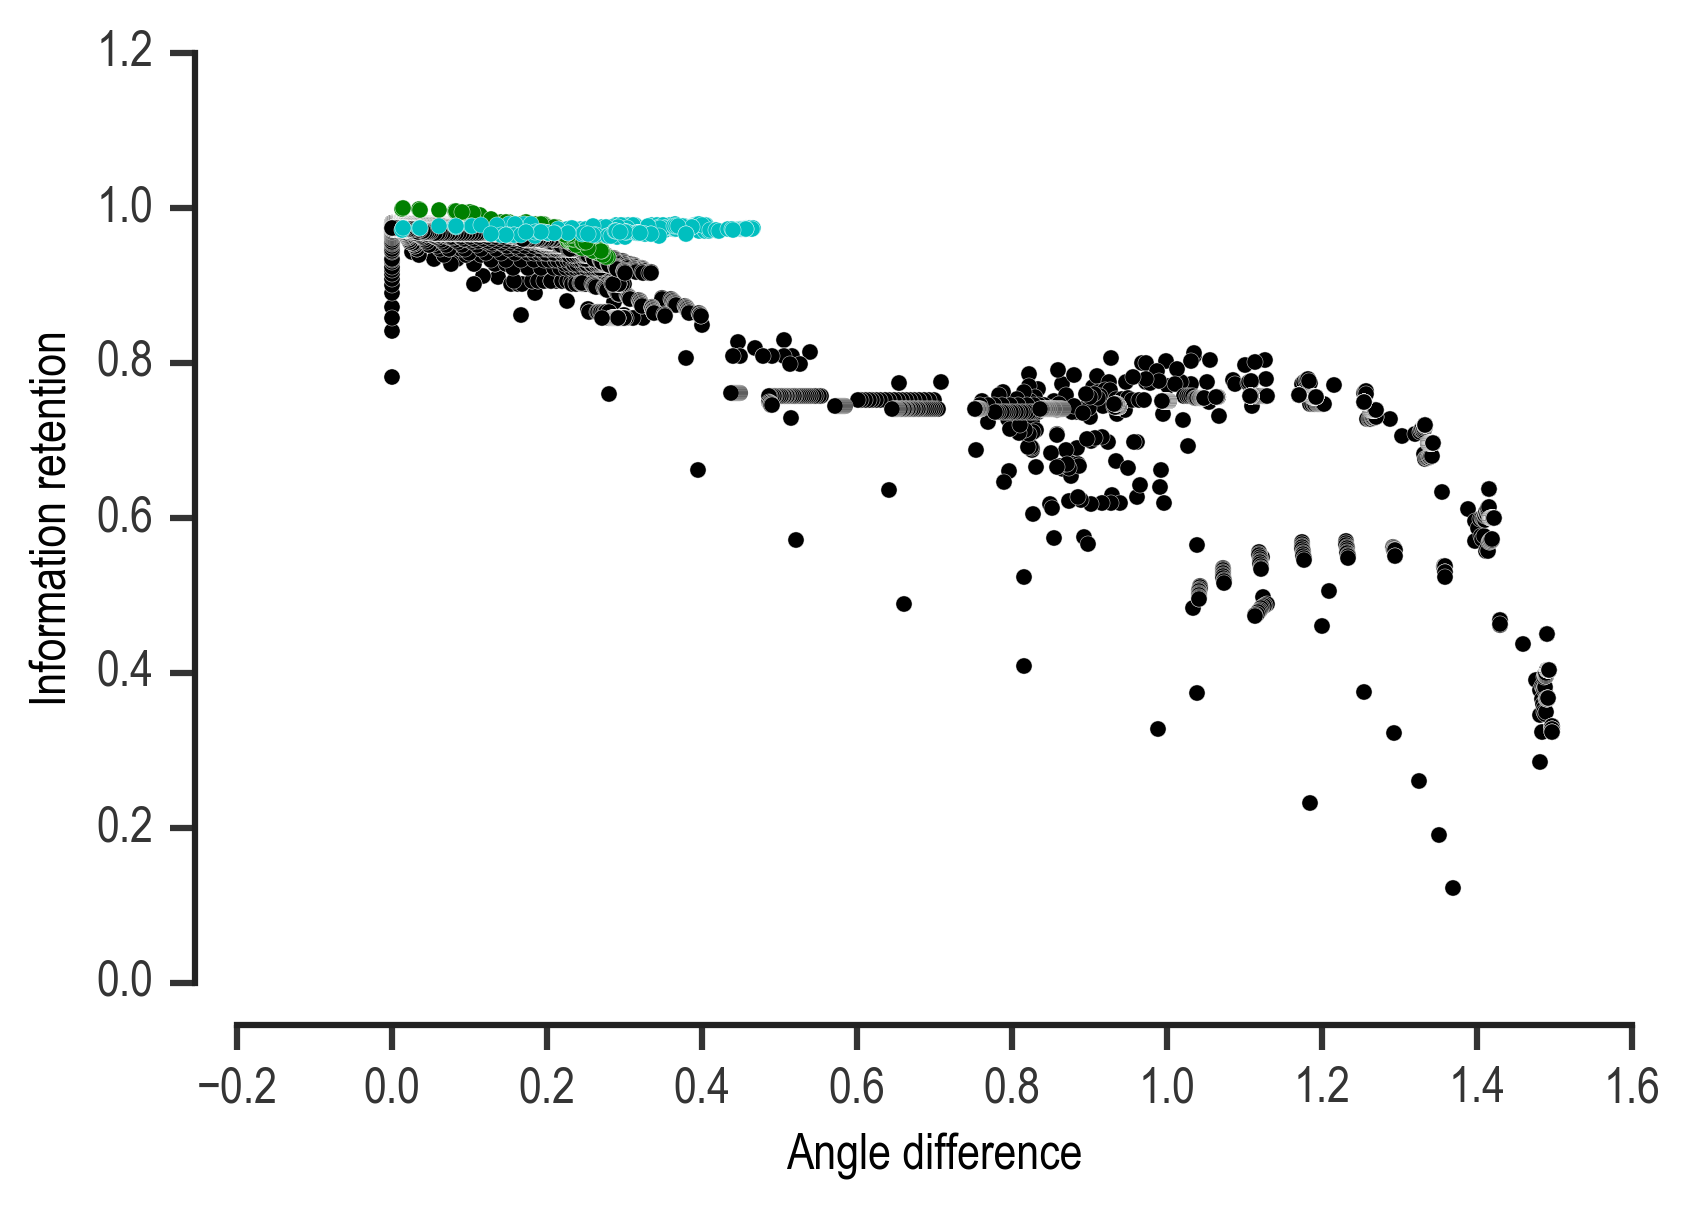

In [104]:
plt.scatter(real_angles_fft, info_difference.ravel(), color='k', edgecolor='w', linewidth=0.1, s=15)
# plt.scatter(max_angles_fft.ravel(), info_difference.ravel(), color='y', edgecolor='w', linewidth=0.1, s=15)
plt.scatter(max_angles_fft_data, max_info_difference_data, color='g', edgecolor='w', linewidth=0.1, s=15)
plt.scatter(angles_fft_data, info_difference_data, color='c', edgecolor='w', linewidth=0.1, s=15)
plt.xlabel('Angle difference')
plt.ylabel('Information retention')
adjust_spines(plt.gca())

Get maximum information across all possible surround widths and horz, center weights

In [105]:
angles_fft_opposite_edges = np.zeros((len(widths), len(widths)))
angles_rf_opposite_edges = np.zeros((len(widths), len(widths)))
info_difference_opposite_edges = np.zeros((len(widths), len(widths)))

center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
center /= -np.sum(center)

for idw1,w1 in enumerate(widths):
    surround1 = gaussian(x=space, sigma=w1, mu=0.)
    surround1 /= np.sum(surround1)
    for idw2,w2 in enumerate(widths[idw1:]):
        surround2 = gaussian(x=space, sigma=w2, mu=0.)
        surround2 /= np.sum(surround2)

        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

        this_map = infos_varying_width[(w1,w2)]
        which_fft = np.unravel_index(this_map.argmax(), this_map.shape)
        hw = horz_weights[which_fft[0]]
        cw = center_weights[which_fft[1]]
        
        mean_info = np.mean(infos_varying_width[(w1,w2)][:, which_fft[1]])

        all_h_rf = rf_model(horz_weights[-1], cw)
        all_a_rf = rf_model(horz_weights[0], cw)
        
        all_h_fft = abs(np.fft.rfft(all_h_rf))
        all_a_fft = abs(np.fft.rfft(all_a_rf))
        
        angle_rf = angle(all_h_rf, all_a_rf)
        if np.isnan(angle_rf):
            angle_rf = 0
            
        angle_fft = angle(all_h_fft, all_a_fft)
        if np.isnan(angle_fft):
            angle_fft = 0
                
        angles_rf_opposite_edges[idw1, idw2+idw1] = angle_rf
        angles_rf_opposite_edges[idw2+idw1, idw1] = angle_rf
        angles_fft_opposite_edges[idw1, idw2+idw1] = angle_fft
        angles_fft_opposite_edges[idw2+idw1, idw1] = angle_fft
        info_difference_opposite_edges[idw1, idw2+idw1] = mean_info/max_info
        info_difference_opposite_edges[idw2+idw1, idw1] = mean_info/max_info

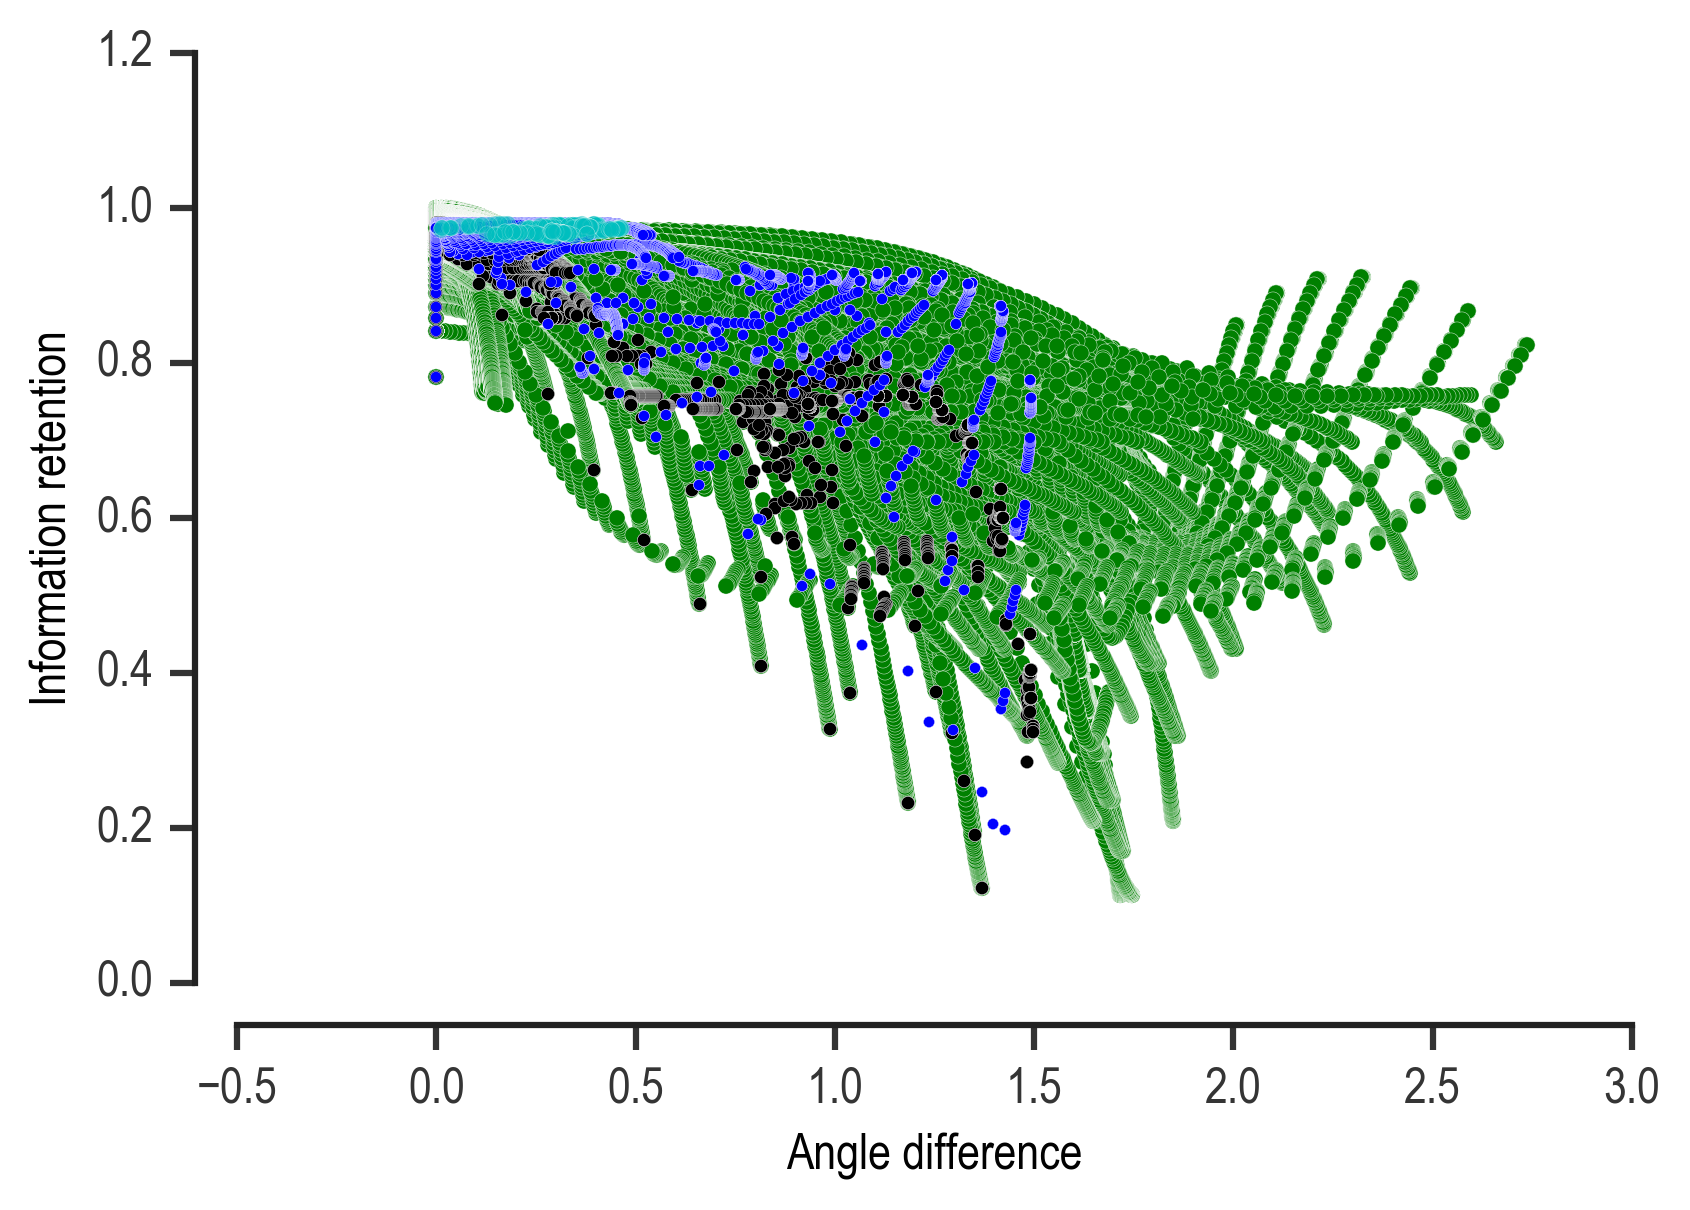

In [106]:
plt.scatter(all_arccos, all_info_losses, color='g', edgecolor='w', linewidth=0.1, s=15)
plt.scatter(max_angles_fft.ravel(), info_difference.ravel(), color='k', edgecolor='w', linewidth=0.1, s=10)
plt.scatter(angles_fft_opposite_edges, info_difference_opposite_edges.ravel(), 
            color='b', edgecolor='w', linewidth=0.1, s=7)
plt.scatter(angles_fft_data, info_difference_data, color='c', edgecolor='w', linewidth=0.1, s=15, alpha=0.5)
# plt.scatter(max_angles_fft_data, info_difference_data, color='g', edgecolor='w', linewidth=0.1, s=15)
plt.xlabel('Angle difference')
plt.ylabel('Information retention')
adjust_spines(plt.gca())

## To recap:  
Green is taking, for all info maps M, the best (hw,cw) pair in M, and then recording the information and diversity for all different possible hw's. So diversity here is between different hw weighted models and the best possible model for that M.  
  
Black is taking, for all info maps M, the best (hw, cw) pair in M, but now just recording the information and diversity for the new hw weighting that produces the largest diversity. So for a given trajectory, we take the rightmost point.  
  
Blue ignores the best model for M, and instead just computes the diversity between hw $\in \{0,1\}$ and the information as the mean information across all possible hw's at the cw$^*$ for which (hw$^*$, cw$^*$) maximizes info on M.


### Choose examples

In [107]:
radians_to_deg = 360./(2.*np.pi)
colors = ['b', 'g', 'r']

In [108]:
example_ids = []
example_angles = []
example_info_loss = []
flag = [0,0,0]
for i,(this_angle,info) in enumerate(zip(angles_fft_opposite_edges.ravel(), info_difference_opposite_edges.ravel())):
    angle_deg = radians_to_deg * this_angle
    info_loss = 100*(1. - info)
    if (angle_deg > 10) and (angle_deg < 20) and (info_loss > 12.) and (info_loss < 50.) and (flag[0] == 0):
        print((angle_deg, info_loss))
        example_ids.append(np.unravel_index(i, angles_fft_opposite_edges.shape))
        example_angles.append(angle_deg)
        example_info_loss.append(info_loss)
        flag[0] = 1
        
    if (angle_deg > 40) and (angle_deg < 44) and (info_loss > 30.) and (flag[1] == 0):
        print((angle_deg, info_loss))
        example_ids.append(np.unravel_index(i, angles_fft_opposite_edges.shape))
        example_angles.append(angle_deg)
        example_info_loss.append(info_loss)
        flag[1] = 1
        
    if (angle_deg > 26) and (angle_deg < 30) and (info_loss < 2.6) and (flag[2] == 0):
        print((angle_deg, info_loss))
        example_ids.append(np.unravel_index(i, angles_fft_opposite_edges.shape))
        example_angles.append(angle_deg)
        example_info_loss.append(info_loss)
        flag[2] = 1

(17.180155022180127, 12.240050283229731)
(41.296894381565522, 31.843836499724819)
(26.031856054849438, 2.1201074476321913)


In [109]:
example_ids

[(2, 3), (5, 13), (17, 80)]

In [110]:
for idw1, idw2 in example_ids:
    print((widths[idw1], widths[idw2]))

(0.35323232323232323, 0.5248484848484849)
(0.86808080808080801, 2.2410101010101009)
(2.9274747474747471, 13.739292929292928)


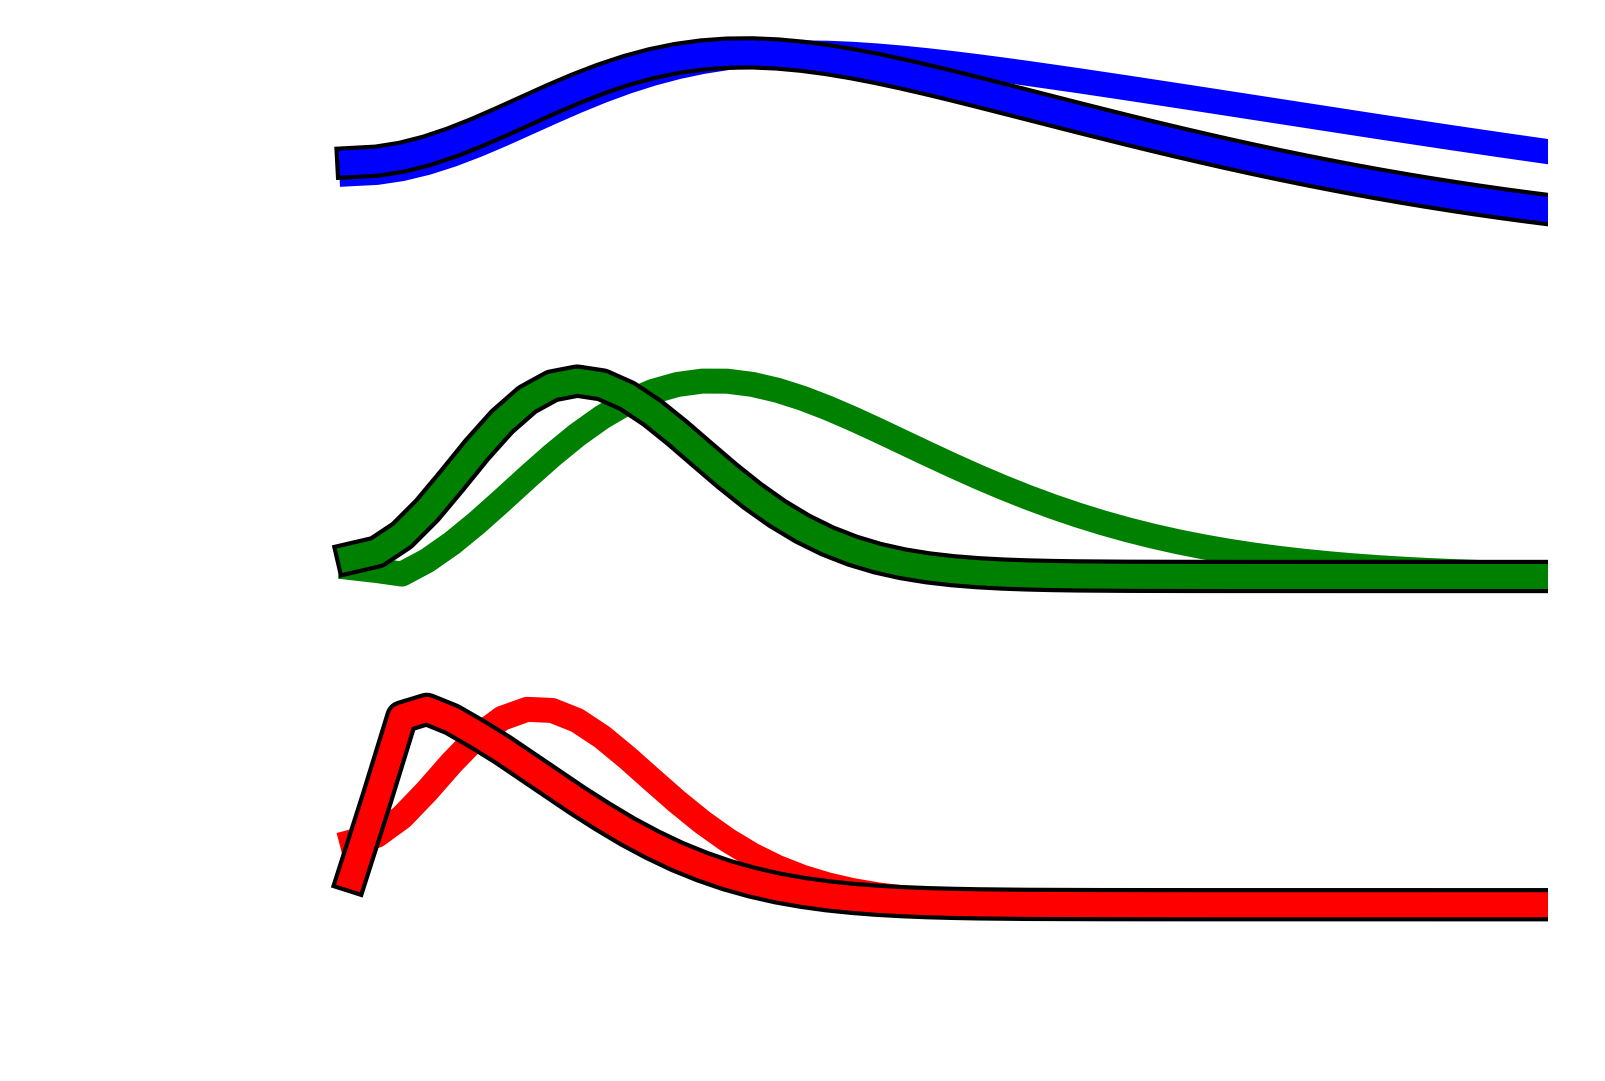

In [111]:
extreme_rfs = collections.defaultdict(list)
center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
center /= -np.sum(center)

for exi, (idw1, idw2) in enumerate(example_ids):
    w1 = widths[idw1]
    w2 = widths[idw2]
    surround1 = gaussian(x=space, sigma=w1, mu=0.)
    surround1 /= np.sum(surround1)
    surround2 = gaussian(x=space, sigma=w2, mu=0.)
    surround2 /= np.sum(surround2)

    def rf_model(horz_weight, center_weight):
        return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

    this_map = infos_varying_width[(w1,w2)]
    which_fft = np.unravel_index(this_map.argmax(), this_map.shape)
    hw = horz_weights[which_fft[0]]
    cw = center_weights[which_fft[1]]

    mean_info = np.mean(infos_varying_width[(w1,w2)][:, which_fft[1]])

    all_h_rf = rf_model(horz_weights[-1], cw)
    all_a_rf = rf_model(horz_weights[0], cw)

    all_h_fft = abs(np.fft.rfft(all_h_rf))
    all_a_fft = abs(np.fft.rfft(all_a_rf))

    # Plot the two RFs
    plt.subplot('31%d' %(exi+1))
    plt.plot(freqs, all_a_fft/np.max(abs(all_a_fft)), color=colors[exi], linewidth=6)
    plt.plot(freqs, all_h_fft/np.max(abs(all_h_fft)), color='k', linewidth=8)
    plt.plot(freqs, all_h_fft/np.max(abs(all_h_fft)), color=colors[exi], linewidth=6)
    plt.axis('off')
    plt.ylim(-.3, 1.1)
    plt.xlim(-.1, .6)
#     plt.title('Diversity %0.2f$^\circ$ -  Information loss %0.1f%%' %(this_angle_fft, 100*(1 - this_info)), 
#               fontsize=18)
#     adjust_spines(plt.gca())
plt.savefig('4-2 extreme RFs.png', transparent=True)

In [137]:
# contour
angle_bins = radians_to_deg * np.linspace(0, 1.4, 180)
info_bins = np.linspace(1.5, 80, 180)
count_2d, angles_edges, info_edges = np.histogram2d(radians_to_deg * np.array(angles_fft_data),
                                                   100*(1 - np.array(info_difference_data)),
                                                   bins=[angle_bins, info_bins])
gauss_2d, bins_x, bins_y = np.histogram2d(samples[:,0], samples[:,1], np.linspace(-5,5,30), normed=True)
smoothed_count_2d = convolve2d(count_2d, gauss_2d**2, mode='same')
smoothed_count_2d[:,0] = 0

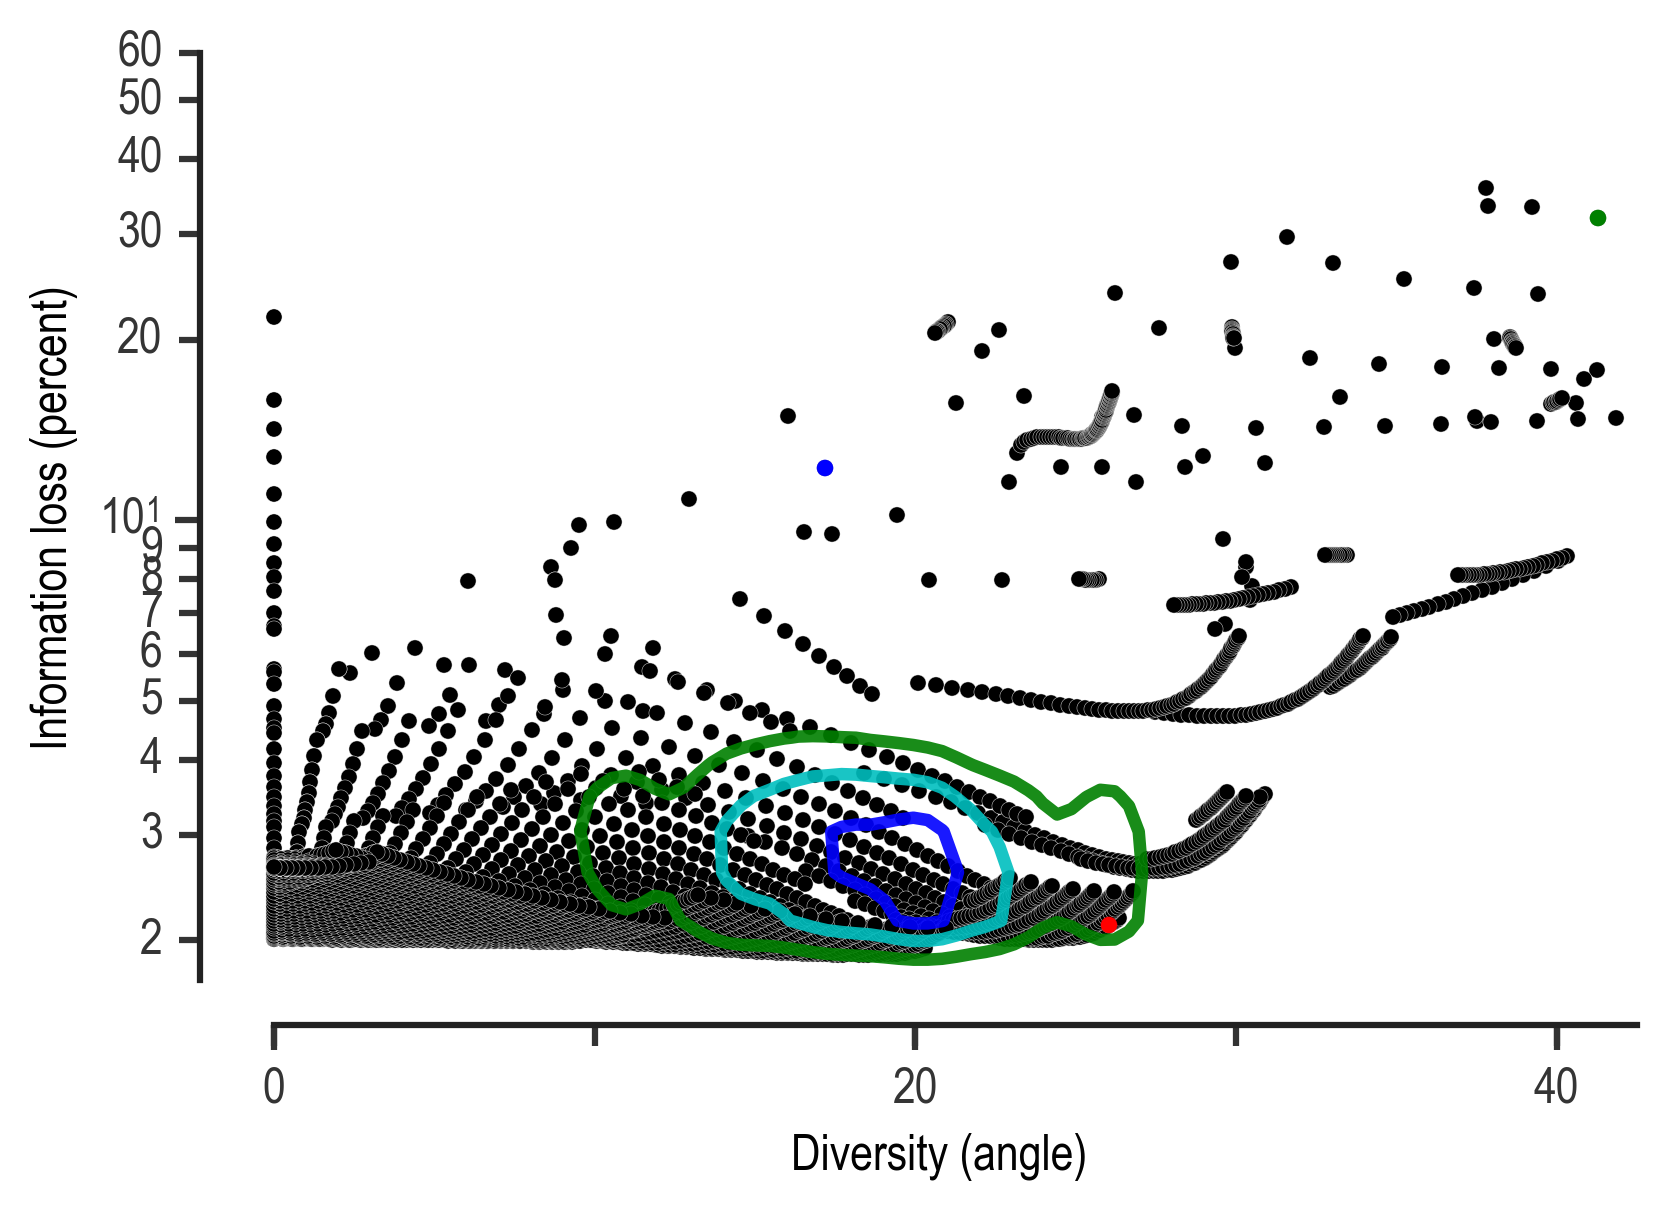

In [155]:
eps = 10e-10
plt.scatter(radians_to_deg*angles_fft_opposite_edges, 100*(1 - info_difference_opposite_edges.ravel()) + eps, color='k', edgecolor='w', linewidth=0.1, s=15)
# plt.scatter(radians_to_deg*np.array(all_arccos),
#             100*(1 - np.array(all_info_losses)) + eps, color='k', edgecolor='w', linewidth=0.1, s=15)

# contour
angle_bins = radians_to_deg * np.linspace(0, 1.4, 180)
info_bins = np.linspace(1.5, 80, 180)
count_2d, angles_edges, info_edges = np.histogram2d(radians_to_deg * np.array(angles_fft_data),
                                                   100*(1 - np.array(info_difference_data)),
                                                   bins=[angle_bins, info_bins])

for exi, (idw1, idw2) in enumerate(example_ids):
    plt.scatter(example_angles[exi], example_info_loss[exi], color=colors[exi], linewidth=0.1, s=15)
# gauss_2d, bins_x, bins_y = np.histogram2d(samples[:,0], samples[:,1], np.linspace(-5,5,30), normed=True)
# smoothed_count_2d = convolve2d(count_2d, gauss_2d**2, mode='same')
# smoothed_count_2d[:,0] = 0

contour_colors = ['g', 'c', 'b']
X, Y = np.meshgrid(angles_edges[:-1] + np.mean(np.diff(angles_edges))/2, 
                   info_edges[:-1] + np.mean(np.diff(info_edges))/2)
CS = plt.contour(X, Y, smoothed_count_2d.T, 3, linewidths=3, alpha=0.9, colors=contour_colors)
# contour_counts = CS.levels
# for i,c in enumerate(contour_counts):
#     plt.text(0.8, 5-1.5*i/2, '%d interneuron cell pairs' %c, fontsize=9, color=contour_colors[i])

majorLocator = MultipleLocator(20)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(10)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)


plt.xlabel('Diversity (angle)')
plt.ylabel('Information loss (percent)')
adjust_spines(plt.gca())
plt.yscale('log')
# plt.ylim(10e-3,80)
ax = plt.gca()
# ax.get_yaxis().get_major_formatter().labelOnlyBase = False
plt.tick_params(axis='y', which='minor')
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.f"))
plt.xlim(-1, 42.5)
plt.ylim(1.7, 60)
# plt.savefig('12-2 information loss vs diversity with data contour with coarse-grained widths.pdf')
plt.savefig('4-2 information loss vs diversity with contours with extreme rfs.pdf')

# In frequency domain

### Change aspect ratio

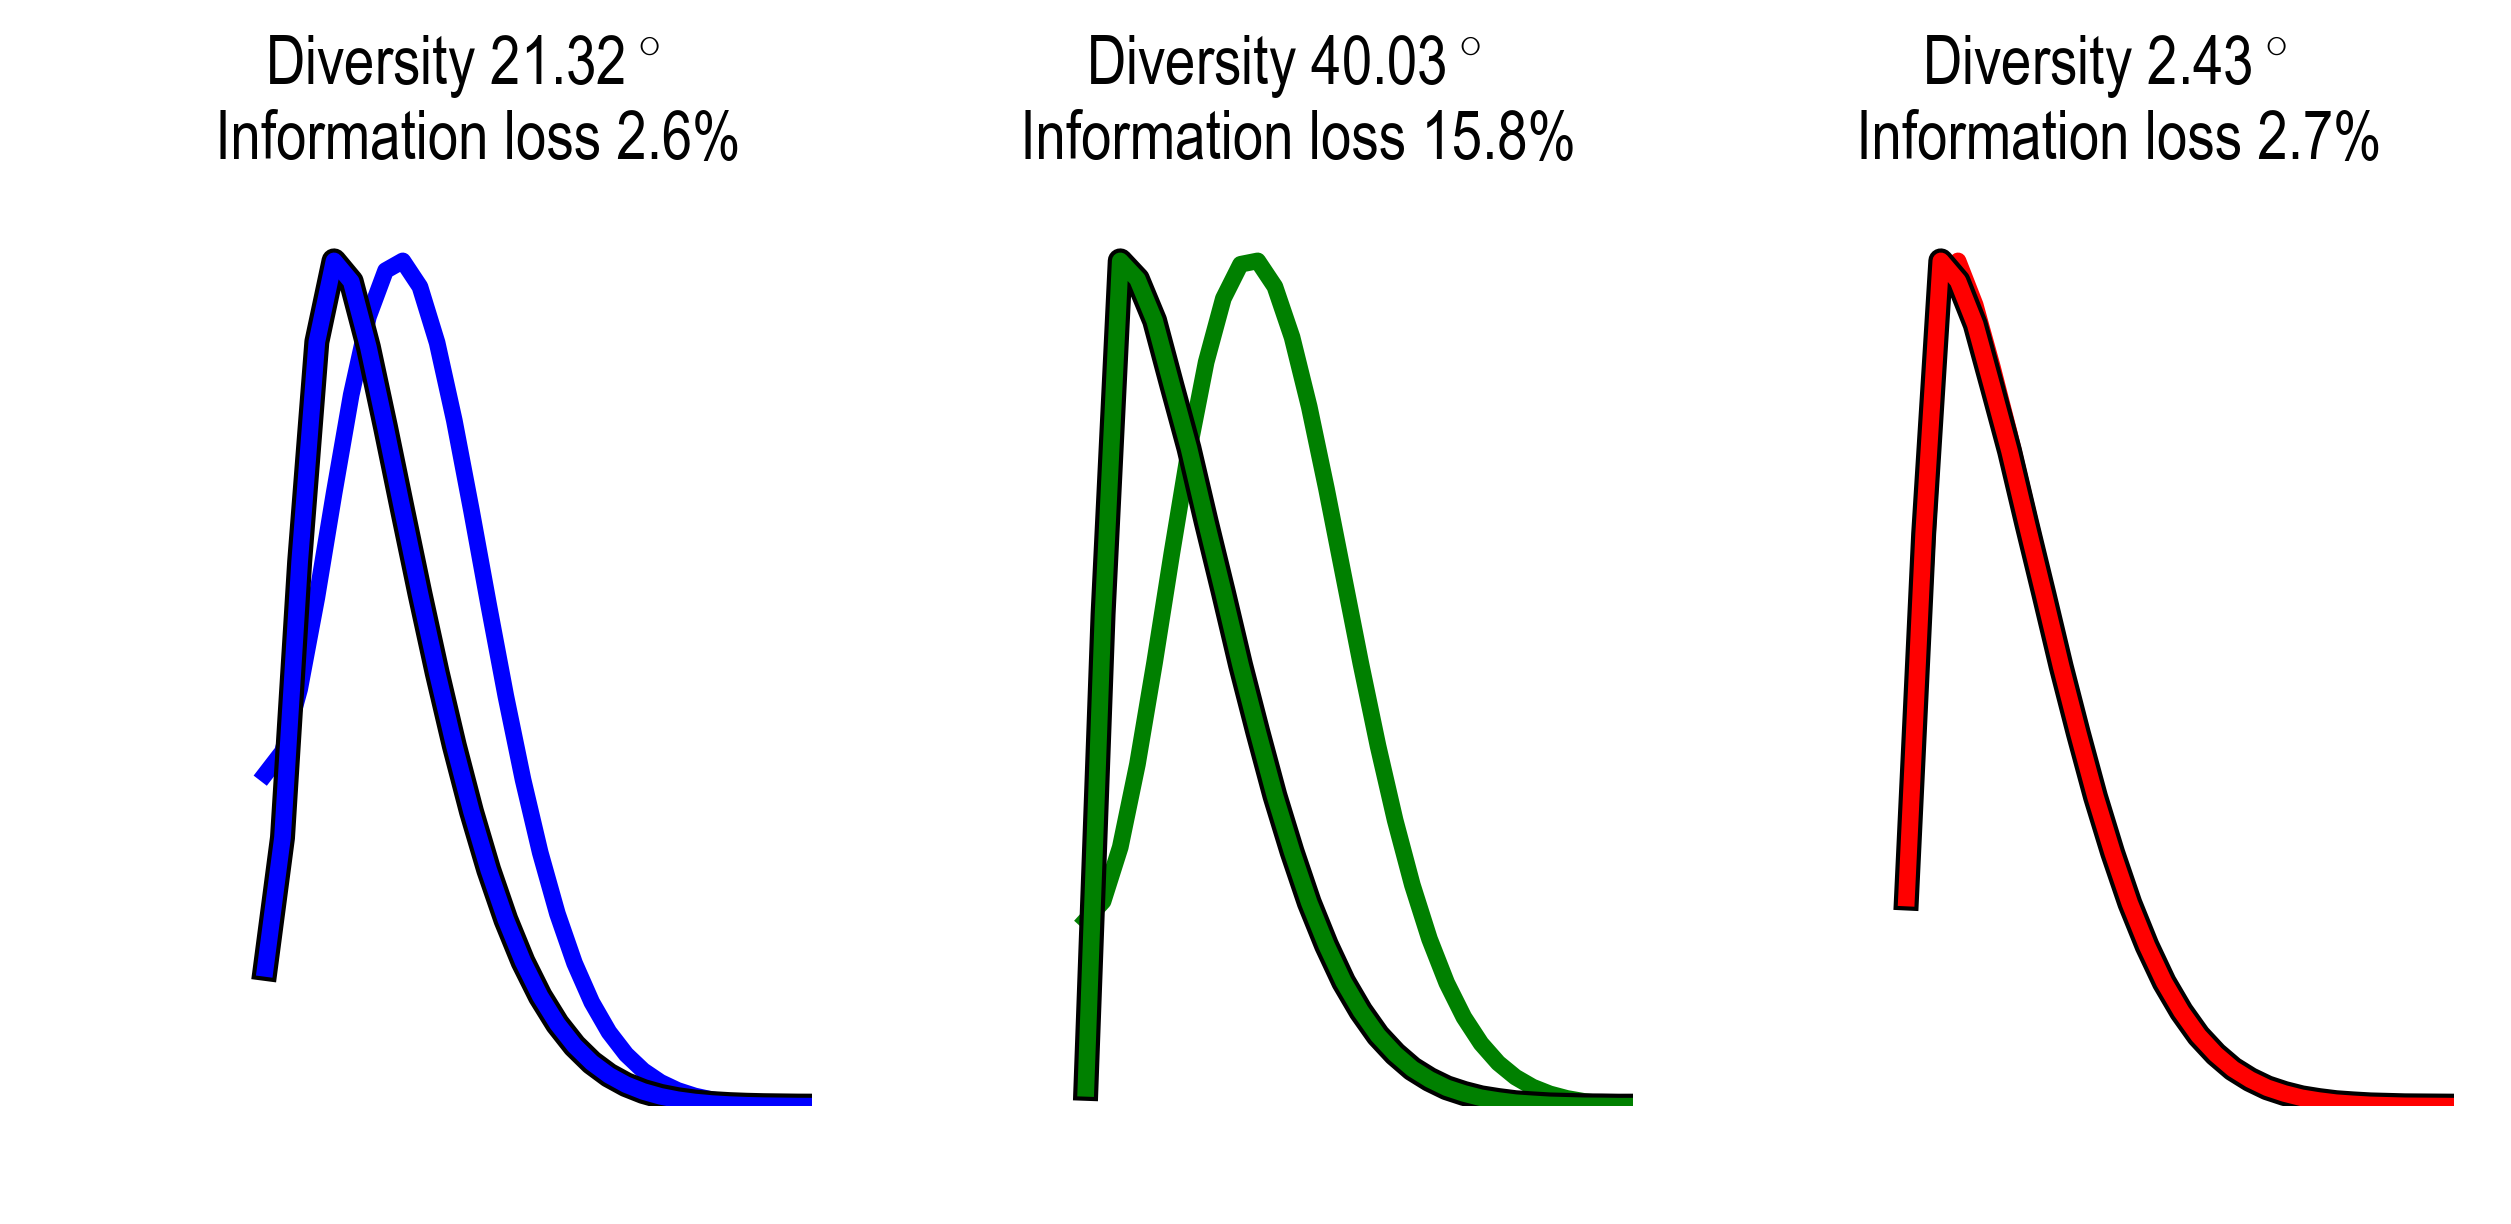

In [178]:
example_indices = [[43, 15], 
                   [96, 11], 
                   [95, 78]]

colors = ['b', 'g', 'r']
fig = plt.gcf()
fig.set_size_inches((10,4))

for exi,ex in enumerate(example_indices):
    w2 = widths[ex[0]]
    w1 = widths[ex[1]]
        
    surround2 = gaussian(x=space, sigma=w2, mu=0.)
    surround2 /= np.sum(surround2)

    surround1 = gaussian(x=space, sigma=w1, mu=0.)
    surround1 /= np.sum(surround1)

    def rf_model(horz_weight, center_weight):
        return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

    this_map = infos_varying_width[(w1,w2)]
    which_fft = np.unravel_index(this_map.argmax(), this_map.shape)
    hw = horz_weights[which_fft[0]]
    cw = center_weights[which_fft[1]]

    mean_info = np.mean(infos_varying_width[(w1,w2)][:, which_fft[1]])

    all_h_rf = rf_model(horz_weights[-1], cw)
    all_a_rf = rf_model(horz_weights[0], cw)

    all_h_fft = abs(np.fft.rfft(all_h_rf))
    all_a_fft = abs(np.fft.rfft(all_a_rf))

    this_angle_rf = angle(all_h_rf, all_a_rf)
    this_angle_fft = angle(all_h_fft, all_a_fft)
    this_info = mean_info/max_info

    # Plot the two RFs
    plt.subplot('13%d' %(exi+1))
    plt.plot(freqs, all_a_fft/np.max(abs(all_a_fft)), color=colors[exi], linewidth=4)
    plt.plot(freqs, all_h_fft/np.max(abs(all_h_fft)), color='k', linewidth=6)
    plt.plot(freqs, all_h_fft/np.max(abs(all_h_fft)), color=colors[exi], linewidth=4)
    plt.axis('off')
    plt.ylim(0, 1.1)
    plt.xlim(-.1, .4)
    plt.title('Diversity %0.2f$^\circ$ \n Information loss %0.1f%%' %(this_angle_fft*radians_to_deg,
                                                                      100*(1 - this_info)), fontsize=16)
#     adjust_spines(plt.gca())
# plt.savefig('12-2 examples blue green red fft.pdf')
# plt.savefig('12-2 examples blue green red fft.png', transparent=True)

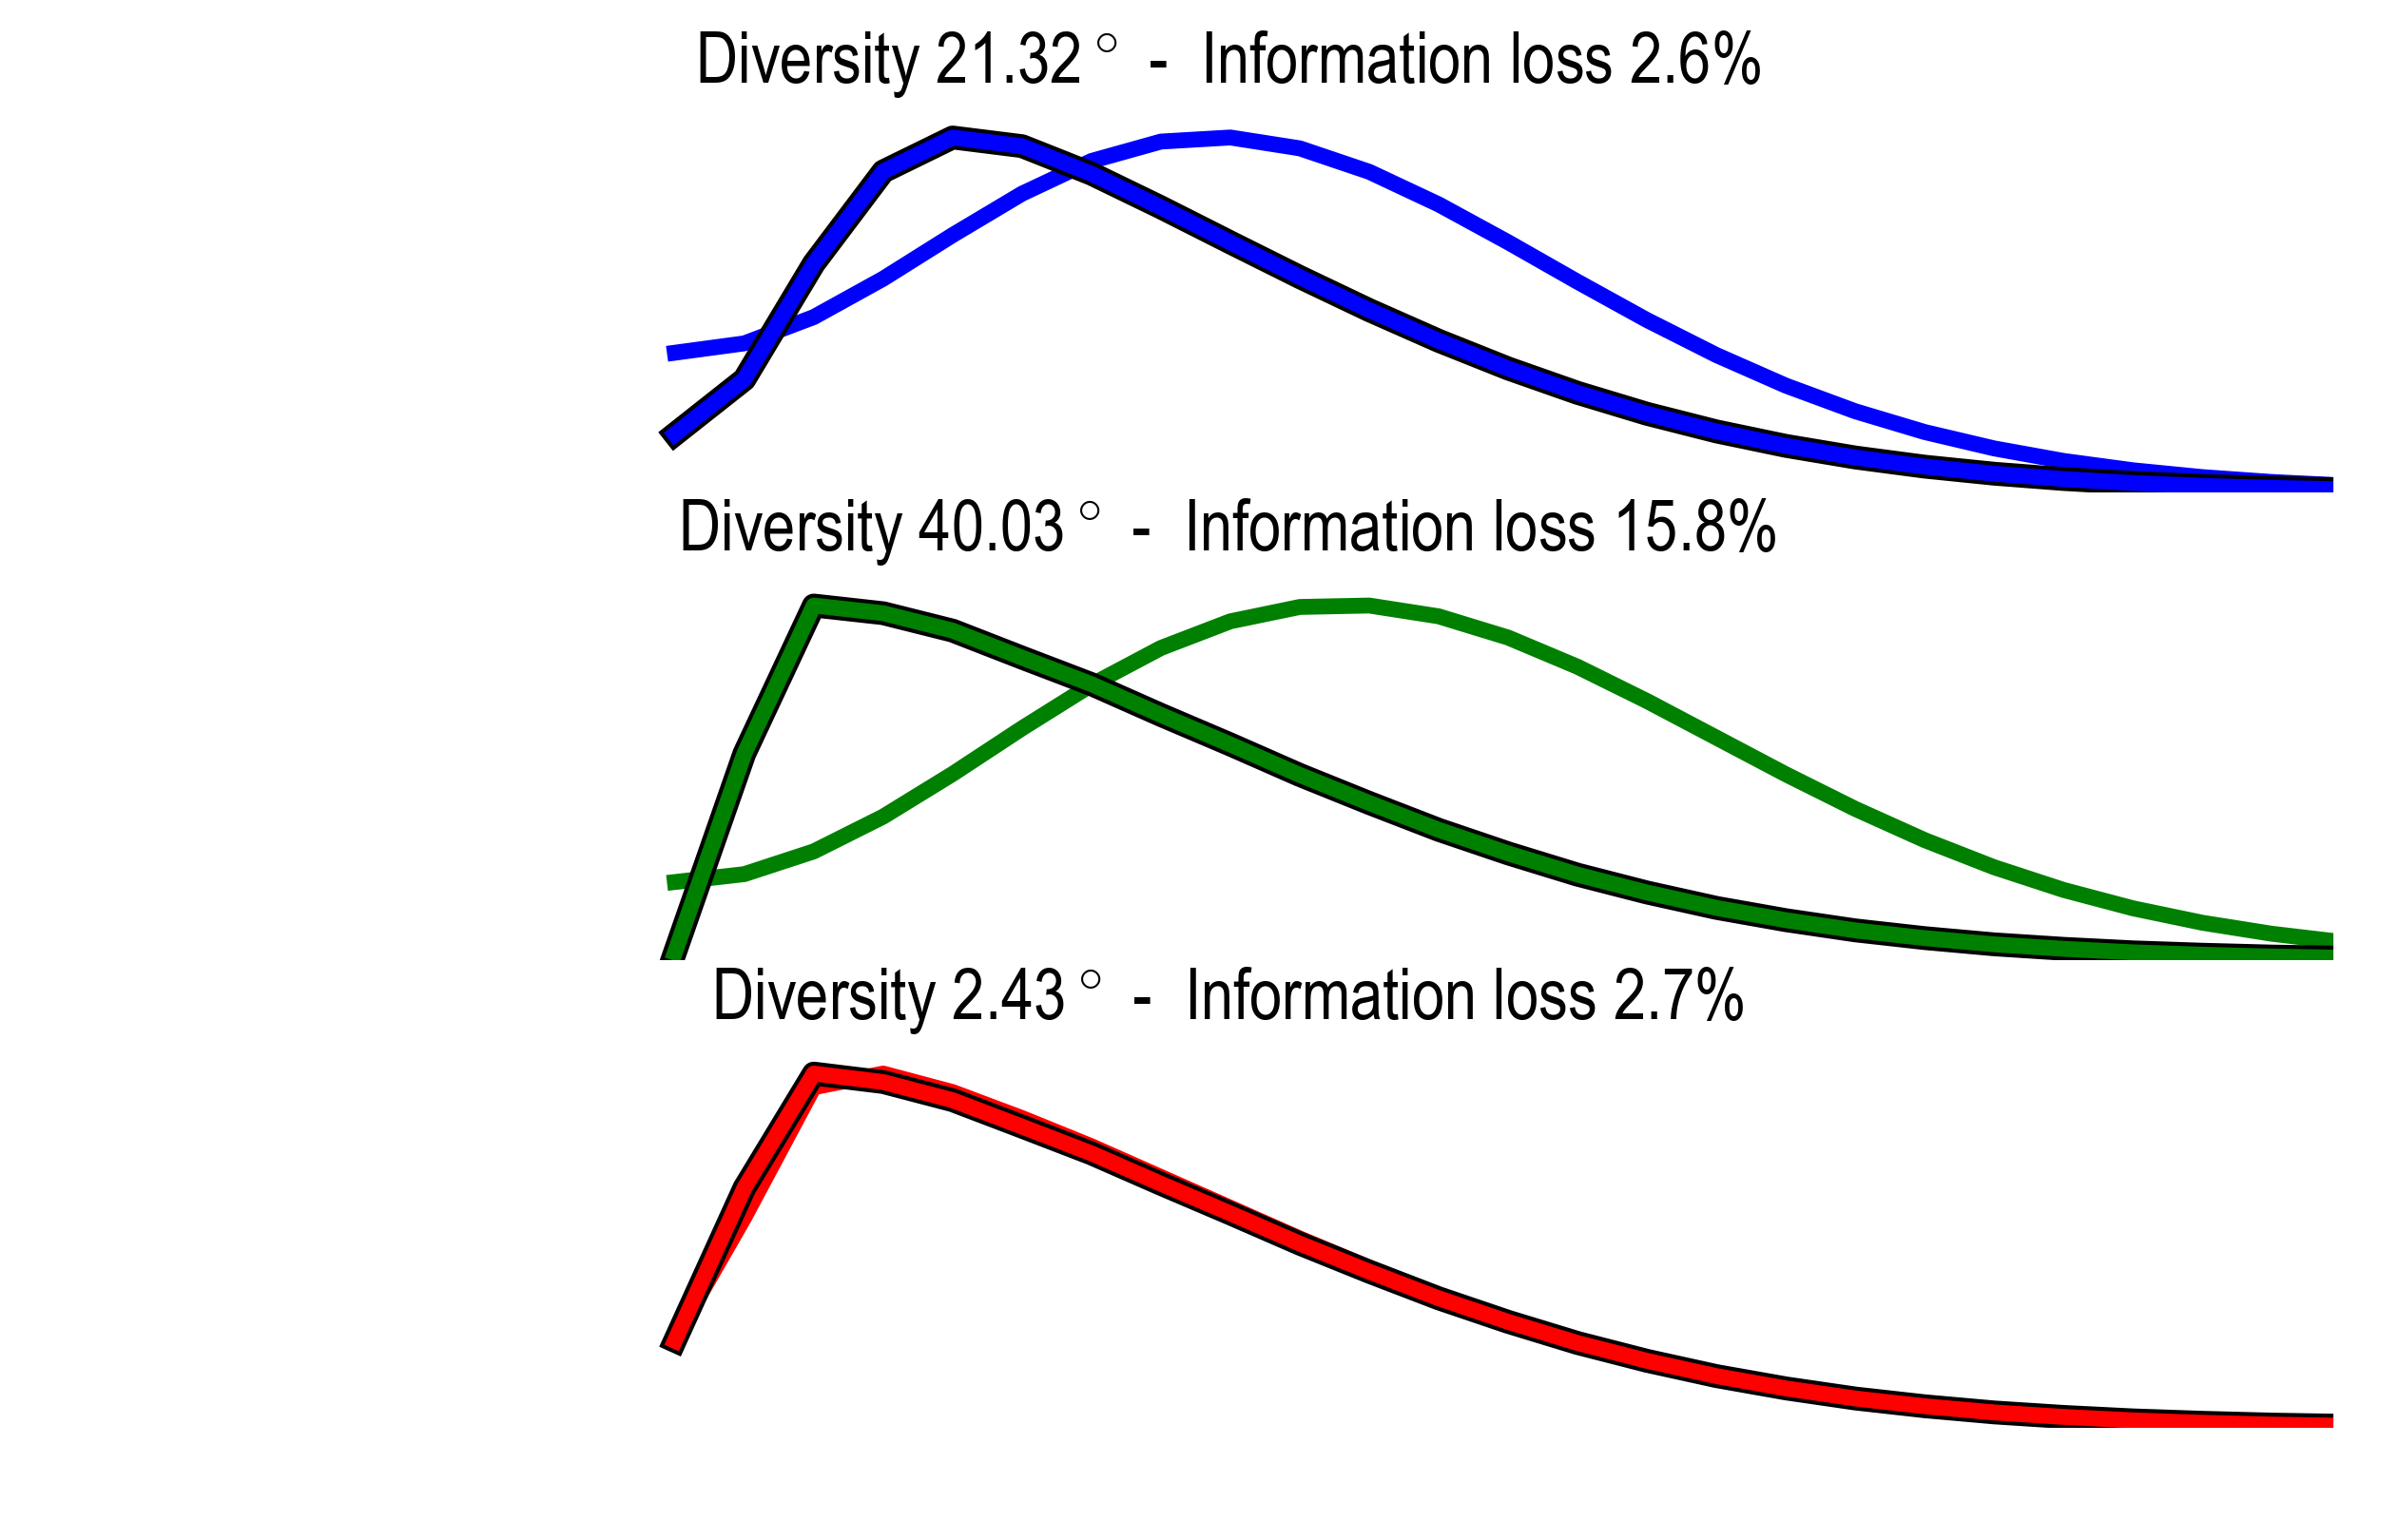

In [179]:
celltype = 'fast_off_adapting'
colors = ['b', 'g', 'r']
fig = plt.gcf()
fig.set_size_inches((10,6))

for exi,ex in enumerate(example_indices):
    w2 = widths[ex[0]]
    w1 = widths[ex[1]]
        
    surround2 = gaussian(x=space, sigma=w2, mu=0.)
    surround2 /= np.sum(surround2)

    surround1 = gaussian(x=space, sigma=w1, mu=0.)
    surround1 /= np.sum(surround1)

    def rf_model(horz_weight, center_weight):
        return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

    this_map = infos_varying_width[(w1,w2)]
    which_fft = np.unravel_index(this_map.argmax(), this_map.shape)
    hw = horz_weights[which_fft[0]]
    cw = center_weights[which_fft[1]]

    mean_info = np.mean(infos_varying_width[(w1,w2)][:, which_fft[1]])

    all_h_rf = rf_model(horz_weights[-1], cw)
    all_a_rf = rf_model(horz_weights[0], cw)

    all_h_fft = abs(np.fft.rfft(all_h_rf))
    all_a_fft = abs(np.fft.rfft(all_a_rf))

    this_angle_rf = angle(all_h_rf, all_a_rf)
    this_angle_fft = angle(all_h_fft, all_a_fft)
    this_info = mean_info/max_info

    # Plot the two RFs
    plt.subplot('31%d' %(exi+1))
    plt.plot(freqs, all_a_fft/np.max(abs(all_a_fft)), color=colors[exi], linewidth=4)
    plt.plot(freqs, all_h_fft/np.max(abs(all_h_fft)), color='k', linewidth=6)
    plt.plot(freqs, all_h_fft/np.max(abs(all_h_fft)), color=colors[exi], linewidth=4)
    plt.axis('off')
    plt.ylim(0, 1.1)
    plt.xlim(-.1, .3)
    plt.title('Diversity %0.2f$^\circ$ -  Information loss %0.1f%%' %(this_angle_fft*radians_to_deg, 100*(1 - this_info)), 
              fontsize=18)
#     adjust_spines(plt.gca())
# plt.savefig('4-2 examples blue green red fft long.pdf')
# plt.savefig('4-2 examples blue green red fft long.png', transparent=True)

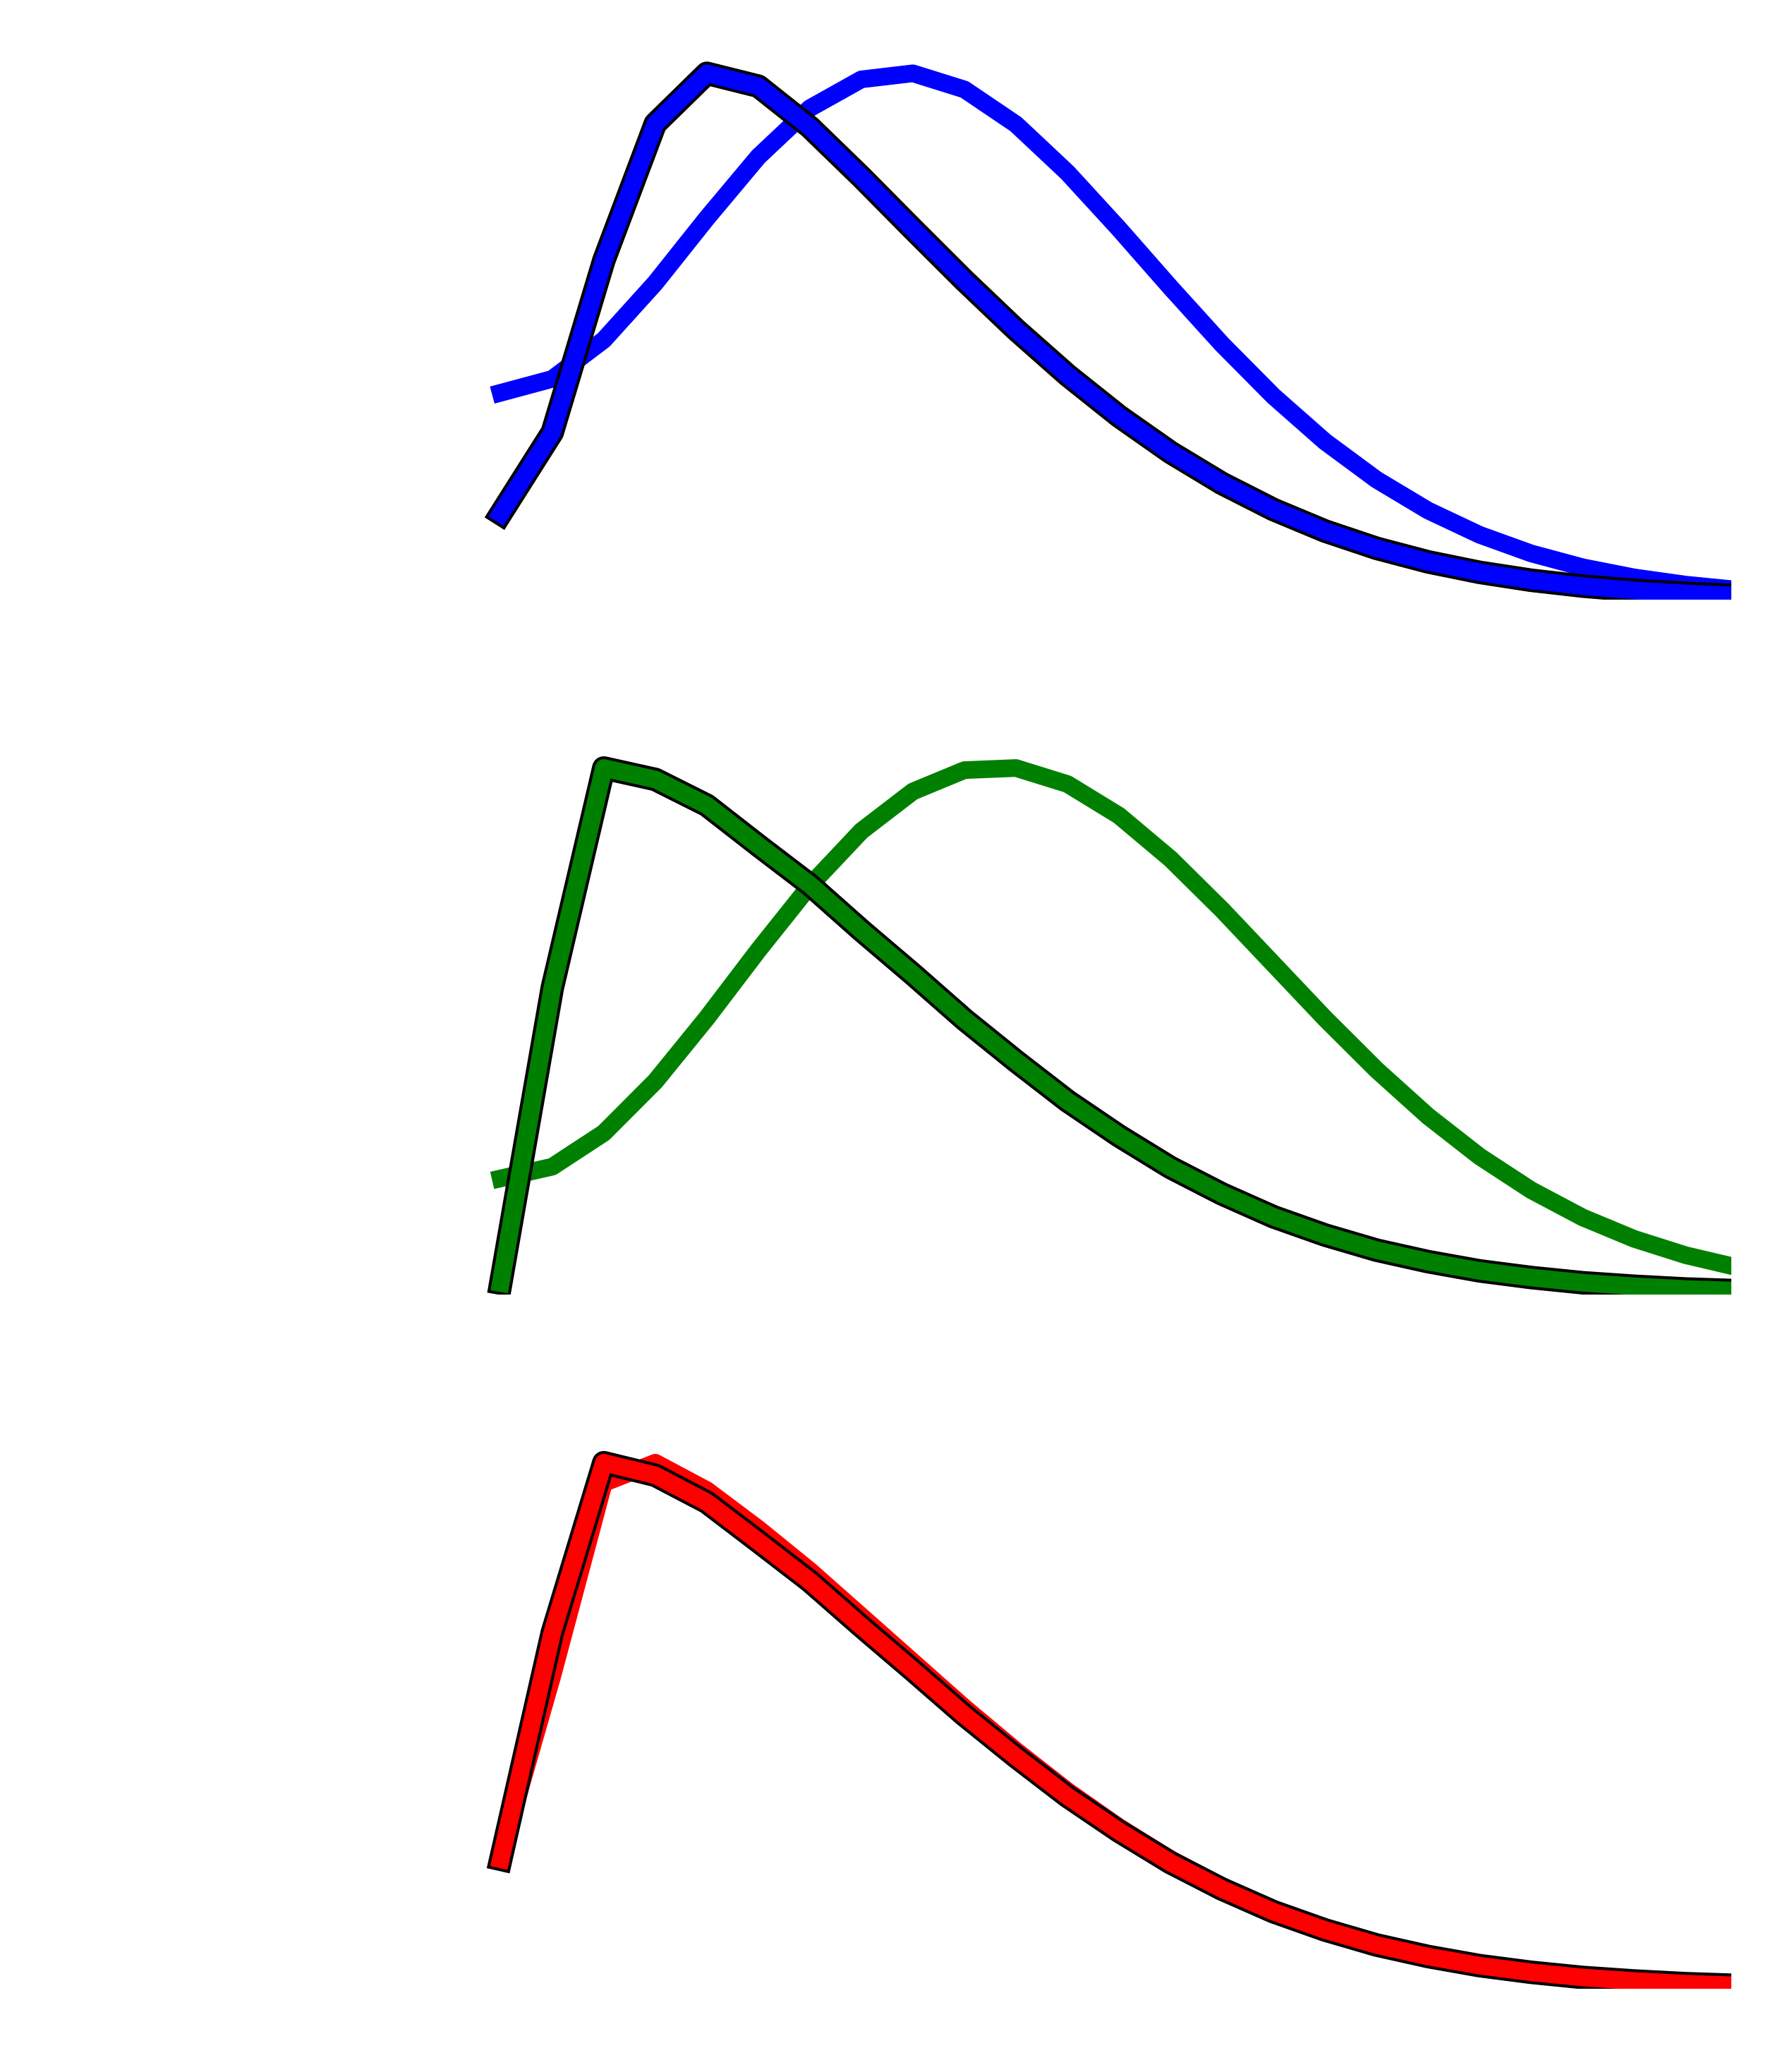

In [180]:
celltype = 'fast_off_adapting'
colors = ['b', 'g', 'r']
fig = plt.gcf()
fig.set_size_inches((10,12))

for exi,ex in enumerate(example_indices):
    w2 = widths[ex[0]]
    w1 = widths[ex[1]]
        
    surround2 = gaussian(x=space, sigma=w2, mu=0.)
    surround2 /= np.sum(surround2)

    surround1 = gaussian(x=space, sigma=w1, mu=0.)
    surround1 /= np.sum(surround1)

    def rf_model(horz_weight, center_weight):
        return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

    this_map = infos_varying_width[(w1,w2)]
    which_fft = np.unravel_index(this_map.argmax(), this_map.shape)
    hw = horz_weights[which_fft[0]]
    cw = center_weights[which_fft[1]]

    mean_info = np.mean(infos_varying_width[(w1,w2)][:, which_fft[1]])

    all_h_rf = rf_model(horz_weights[-1], cw)
    all_a_rf = rf_model(horz_weights[0], cw)

    all_h_fft = abs(np.fft.rfft(all_h_rf))
    all_a_fft = abs(np.fft.rfft(all_a_rf))

    this_angle_rf = angle(all_h_rf, all_a_rf)
    this_angle_fft = angle(all_h_fft, all_a_fft)
    this_info = mean_info/max_info

    # Plot the two RFs
    plt.subplot('31%d' %(exi+1))
    plt.plot(freqs, all_a_fft/np.max(abs(all_a_fft)), color=colors[exi], linewidth=6)
    plt.plot(freqs, all_h_fft/np.max(abs(all_h_fft)), color='k', linewidth=8)
    plt.plot(freqs, all_h_fft/np.max(abs(all_h_fft)), color=colors[exi], linewidth=6)
    plt.axis('off')
    plt.ylim(0, 1.1)
    plt.xlim(-.1, .3)
#     plt.title('Diversity %0.2f$^\circ$ -  Information loss %0.1f%%' %(this_angle_fft, 100*(1 - this_info)), 
#               fontsize=18)
#     adjust_spines(plt.gca())
plt.savefig('4-2 examples blue green red fft long wo titles.png', transparent=True)

In [181]:
half_angles_fft = np.copy(angles_fft_opposite_edges)
for i in range(angles_fft_opposite_edges.shape[0]):
    for j in range(i+1, angles_fft_opposite_edges.shape[1]):
        half_angles_fft[j,i] = 1

In [182]:
samples = np.random.multivariate_normal([0,0], np.eye(2), (1000000))
gauss_2d, bins_x, bins_y = np.histogram2d(samples[:,0], samples[:,1], np.linspace(-4,4,20), normed=True) 
smoothed_interneuron_pairs = convolve2d(interneuron_pairs, gauss_2d, mode='same')

(1.726161616161616, 17.0)

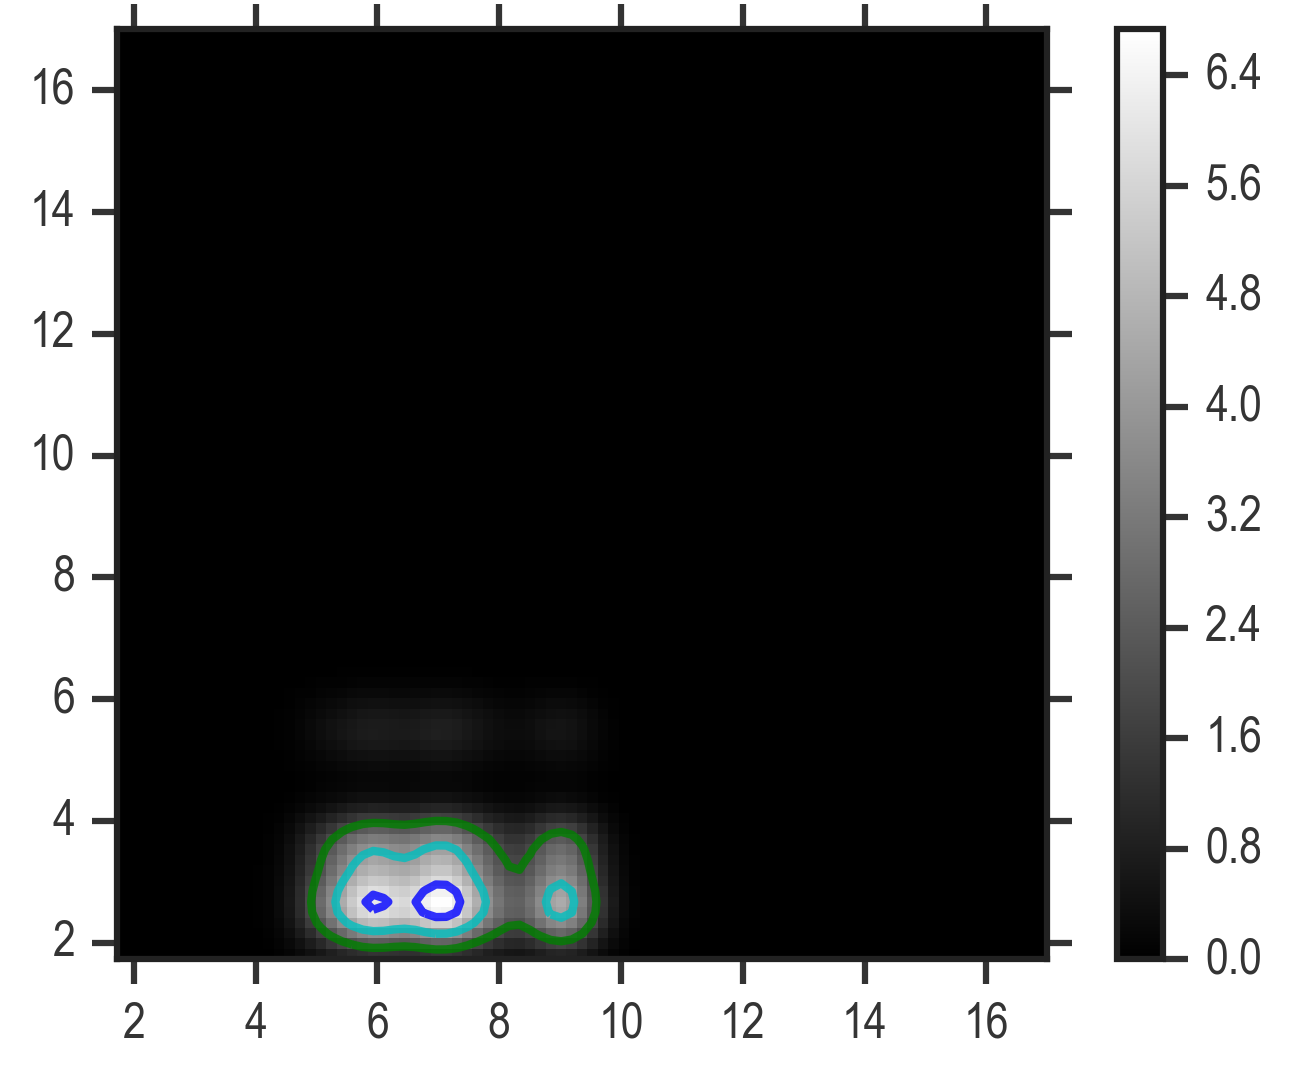

In [183]:
plt.imshow(smoothed_interneuron_pairs.T, origin='bottom left', 
                extent=[widths[0], widths[-1], widths[0], widths[-1]])
plt.colorbar()
X, Y = np.meshgrid(horz_edges[:-1] + bar_width/2, ama_edges[:-1] + bar_width/2)
CS = plt.contour(X, Y, smoothed_interneuron_pairs.T, 3, linewidths=2, alpha=0.8, colors=contour_colors)
plt.xlim(widths[starting_width_idx], widths[-1])
plt.ylim(widths[starting_width_idx], widths[-1])

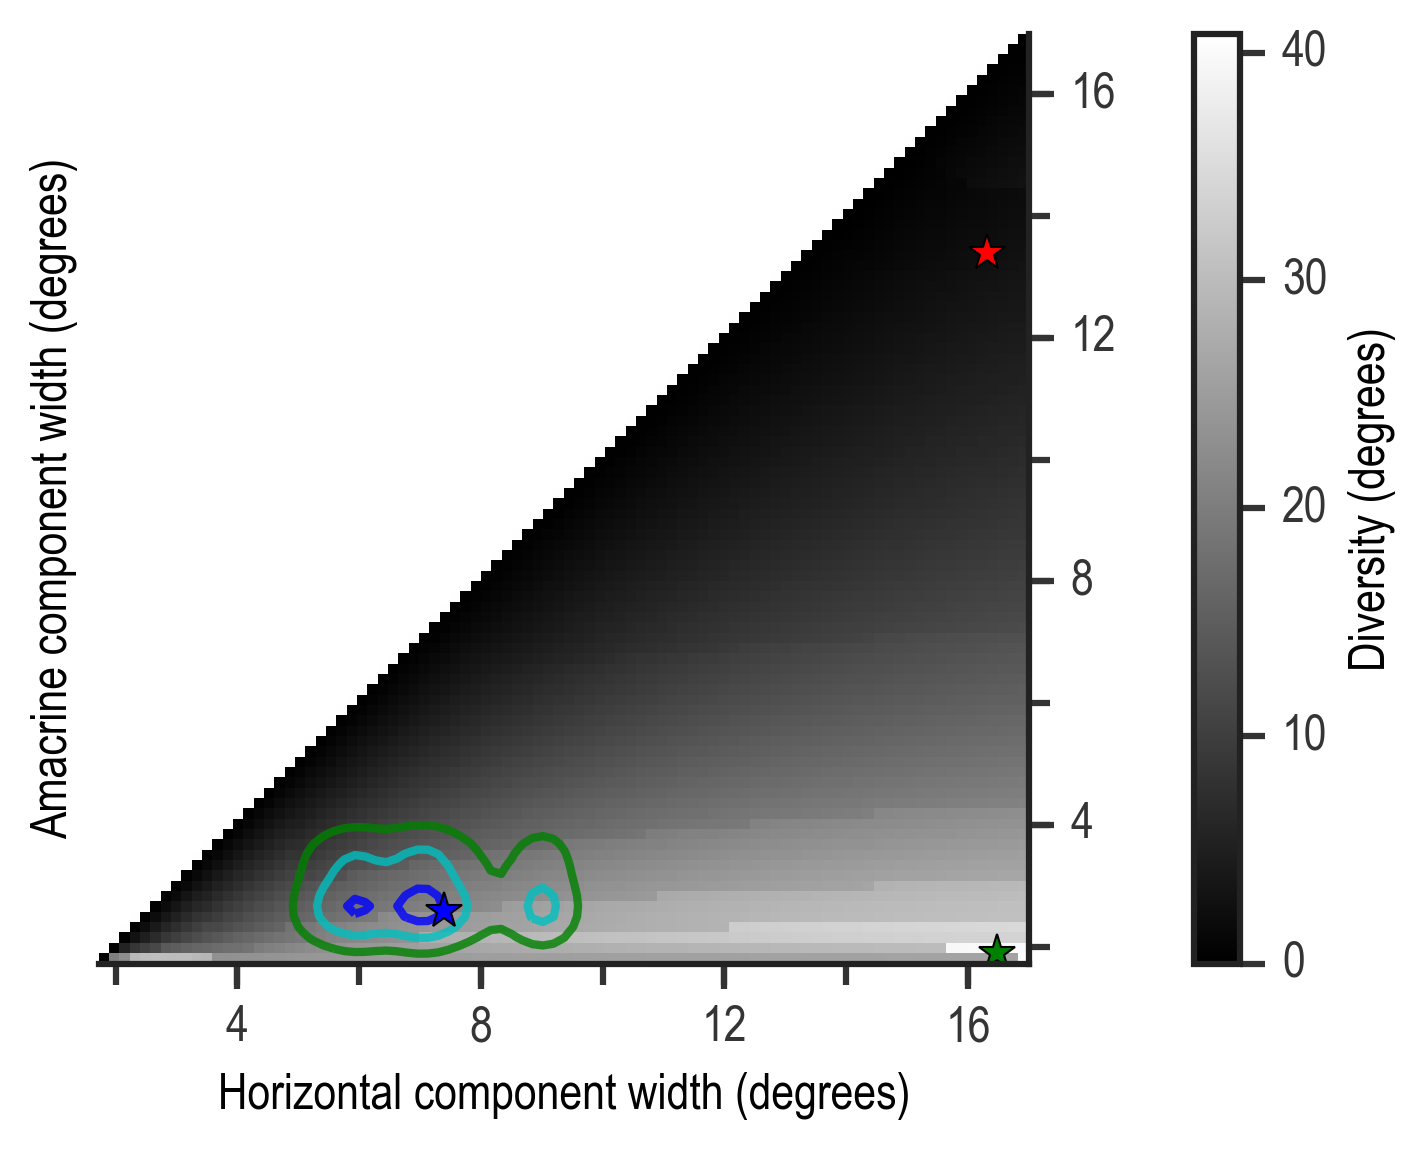

In [185]:
starting_width_idx = 10
ax = plt.gca()
im = plt.imshow(radians_to_deg*half_angles_fft[starting_width_idx:, starting_width_idx:], origin='bottom left', 
                extent=[widths[starting_width_idx], widths[-1], widths[starting_width_idx], widths[-1]],
               clim=[0, np.max(np.tril(radians_to_deg*half_angles_fft[starting_width_idx:, starting_width_idx:].T, k=-1))])
# plt.title('angle between horz only \n and ama only ffts', fontsize=9)
plt.xlim(widths[starting_width_idx], widths[-1])
plt.ylim(widths[starting_width_idx], widths[-1])
plt.xlabel('Horizontal component width (degrees)')

colors = ['b', 'g', 'r']
for exi,ex in enumerate(example_indices):
    plt.plot(widths[ex[0]], widths[ex[1]], colors[exi], marker='*', markersize=9, alpha=1)

# contour
contour_colors = ['g', 'c', 'b']
bar_width = np.mean(np.diff(horz_edges))
X, Y = np.meshgrid(horz_edges[:-1] + bar_width/2, ama_edges[:-1] + bar_width/2)
CS = plt.contour(X, Y, smoothed_interneuron_pairs.T, 3, linewidths=2, alpha=0.8, colors=contour_colors)


majorLocator = MultipleLocator(4)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(2)

ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)

# axes
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('right')
ax.xaxis.set_ticks_position('bottom')
plt.ylabel('Amacrine component width (degrees)')
divider = make_axes_locatable(ax)
cax2 = divider.append_axes("right", size="5%", pad=0.55)
cbar = plt.colorbar(im, cax=cax2)
cbar.ax.set_ylabel('Diversity (degrees)', fontsize=12)
cbar.set_ticks([0, 10, 20, 30, 40])

plt.savefig('lower triangle of diversity smoothed contours with examples degrees 4-2.png', transparent=True)